In [1]:
library(dplyr)
library(vroom)
library(ggplot2)
library(ggpubr)
library(viridis)
library(tidyr)
library(patchwork)
library(gt)
library(readr)
library(purrr)
library(stringr)

# Plotting params
DEFAULT_TEXT_SIZE <- 14

# Globals
MATRIX <- "results/05_Final-Matrix/MA0139.2-final_matrix.tsv"
ACTIVITY <- "results/01_Annotate-rDHS/GRCh38-cCRES.CTCF_signal.activity.tsv"
SIGNAL_MATRIX <- "results/01_Annotate-rDHS/GRCh38-cCRES.CTCF_signal.preprocess.tsv"

# Set working dir
setwd("/data/ruderferlab/projects/biovu/cnv/cre/CTCF-Variant-Annotation/snakemake/workflows/projects/deltaActivity_encode");

# Color codes
GENERAL_COLOR <- "#8491B4FF"
GOB_COLOR_CODE <- "#3C5488FF"
LOB_COLOR_CODE <- "#00A087FF"

# Figure paths
MAIN_FIGURE_DIR <- "results/figures/main"
SUPP_FIGURE_DIR <- "results/figures/supp"

# Misc data path
MOTIF_COUNTS_BY_RDHS <- "results/figures/data/motif_counts_by_rdhs.tsv"
RAW_CCRES <- "resources/data/encode/GRCh38-cCREs.bed"
CTCF_BOUND_REPLICATED <- "results/figures/data/ctcf_bound_replicated.csv"


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘viridis’ was built under R version 4.3.2”
Loading required package: viridisLite

Registered S3 methods overwritten by 'readr':
  method                    from 
  as.data.frame.spec_tbl_df vroom
  as_tibble.spec_tbl_df     vroom
  format.col_spec           vroom
  print.col_spec            vroom
  print.collector           vroom
  print.date_names          vroom
  print.locale              vroom
  str.col_spec              vroom


Attaching package: ‘readr’


The following objects are masked from ‘package:vroom’:

    as.col_spec, col_character, col_date, col_datetime, col_double,
    col_factor, col_guess, col_integer, col_logical, col_number,
    col_skip, col_time, cols, cols_condense, cols_only, date_names,
    date_names_lang, date_names_langs, default_loca

## Setup

In [2]:
# File paths
MATRIX <- "results/05_Final-Matrix/MA0139.2-final_matrix.tsv"
ACTIVITY_ANNO <- "results/01_Annotate-rDHS/GRCh38-cCRES.CTCF_signal.activity.tsv"

# Read matrix
matrix <- vroom(MATRIX, show_col_types = FALSE)

# Read in all rDHS annotated with activity - not just those in the matrix (motif support)
activity_anno <- vroom(ACTIVITY_ANNO, show_col_types = FALSE)

# Add quantiles
activity_anno <- activity_anno %>% 
  mutate(activity_quantile = ntile(zscore_meta_masked, 100))

# Merge on rDHS
matrix <- left_join(matrix, activity_anno, by = "rDHS")

# Add "LoB" if dpwm > 0 and "GoB" if dpwm <= 0
matrix <- matrix %>% 
  mutate(dpwm_class = ifelse(dpwm > 0, "LoB", "GoB"))

# Add significance of dpwm
matrix <- matrix %>% 
  mutate(pwm_stat_class = ifelse(dpwm_rank_pval_log10 > 1.3, 1, 0))

# Main Figures

## Figure 1

### 1A

In [3]:
###
# Plot data
###

# Read in subset of signal matrix for plotting
signal_matrix <- suppressMessages(vroom(SIGNAL_MATRIX, n_max = 50, show_col_types=FALSE))

# Select 10 randome cols (tissues) for heatmap
set.seed(123)
random_tissues <- names(signal_matrix %>% 
  select(-rDHS, -zscore_meta, -zscore_meta_masked, -chrm, -pos0, -pos1) %>%
  select(sample(214, 25)))

# Make input matrix, subset to random tissues
plot_data <- signal_matrix %>% 
    select(-chrm, -pos0, -pos1, -zscore_meta, -zscore_meta_masked) %>% 
    pivot_longer(cols = -c(rDHS), names_to = "tissue", values_to = "zscore") %>%
    filter(tissue %in% random_tissues)

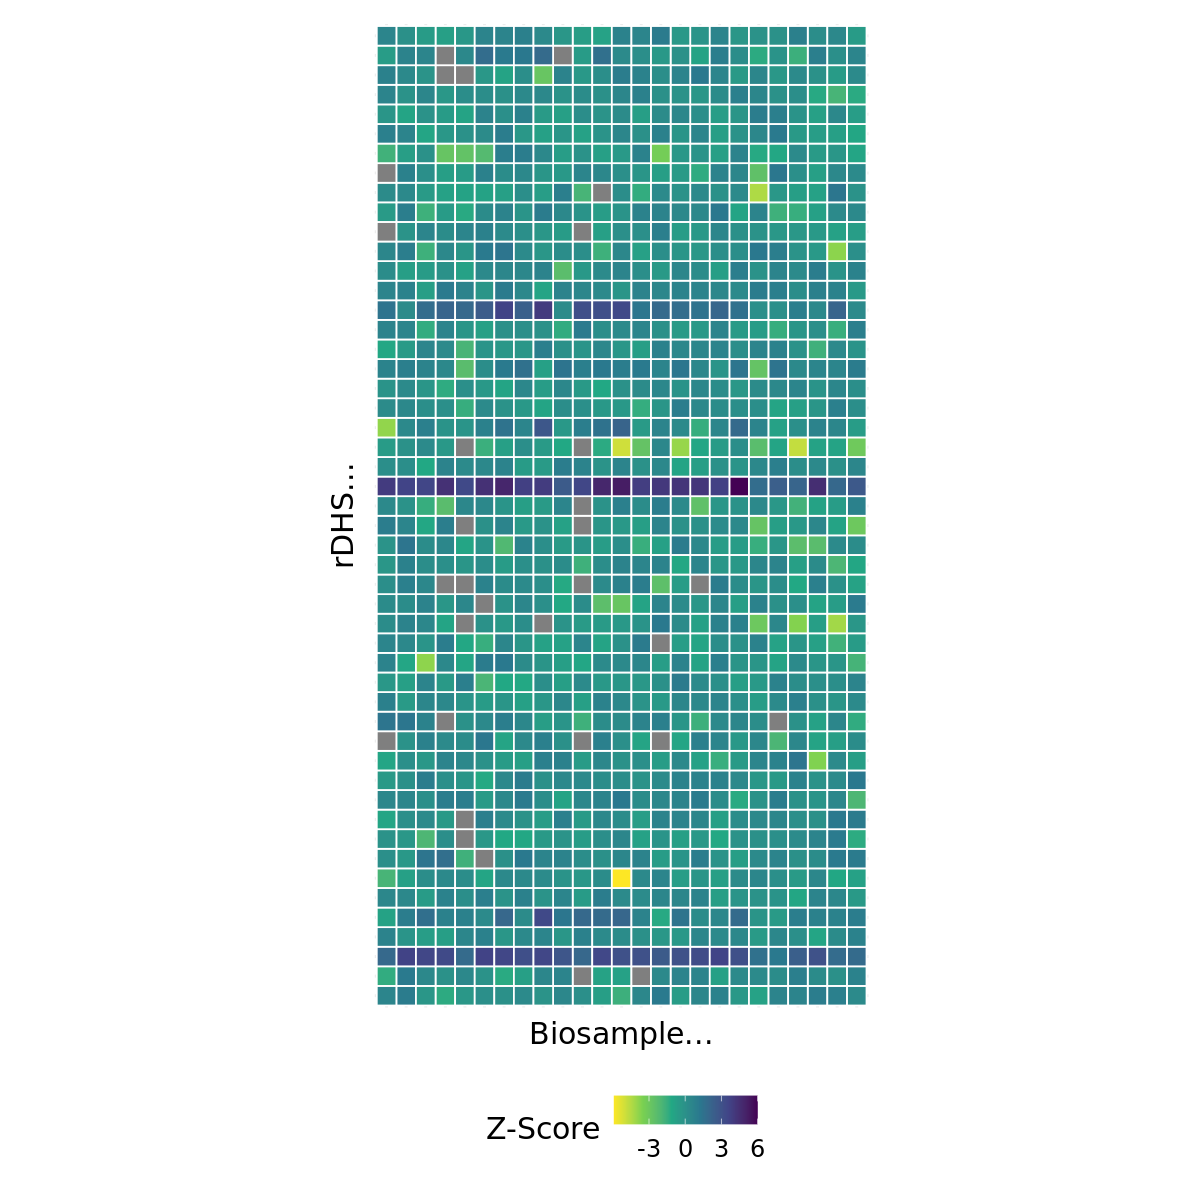

In [8]:
# Make plot
F1A <- ggplot(plot_data, aes(y = rDHS, x = tissue, fill = zscore)) +
  geom_tile(color='white', size=0.5) +
  coord_equal() +
  theme(legend.text = element_text(size=14, angle = 00, margin = margin(t = 2))) +
  scale_fill_viridis_c(option = "viridis", direction = -1)


# Tidy up
F1A <- ggpar(F1A, 
  xlab = "Biosample...",
  ylab="rDHS...", 
  legend = "bottom",
  legend.title = "Z-Score",
  legend.title.align = 0.5,
  legend.title.fontface = "bold",
  legend.title.size = 10,
  legend.ticks.size=10,
  ggtheme = theme_minimal(18),
  ticks = FALSE,
  tickslab = FALSE,
) 

###
# Plotting
###

# Params
width <- 10
height <- 10
figname <- paste(MAIN_FIGURE_DIR, "F1", "F1A.png", sep = "/")
options(repr.plot.width=width, repr.plot.height=height)

# Arrange the plots
(F1A) + plot_annotation() & theme(plot.tag = element_text(face = "bold"))

# Save figure, 300 dpi
ggsave(figname, width = width, height = height, dpi = 300)

[1] "Running..."
[1] "Read in PWM."
[1] "Loaded fasta."


Finished testing motif No. 1

Loading required namespace: Cairo

Loading required namespace: Cairo

Loading required namespace: Cairo

Loading required namespace: Cairo

Loading required namespace: Cairo

Loading required namespace: Cairo

Loading required namespace: Cairo

Loading required namespace: Cairo



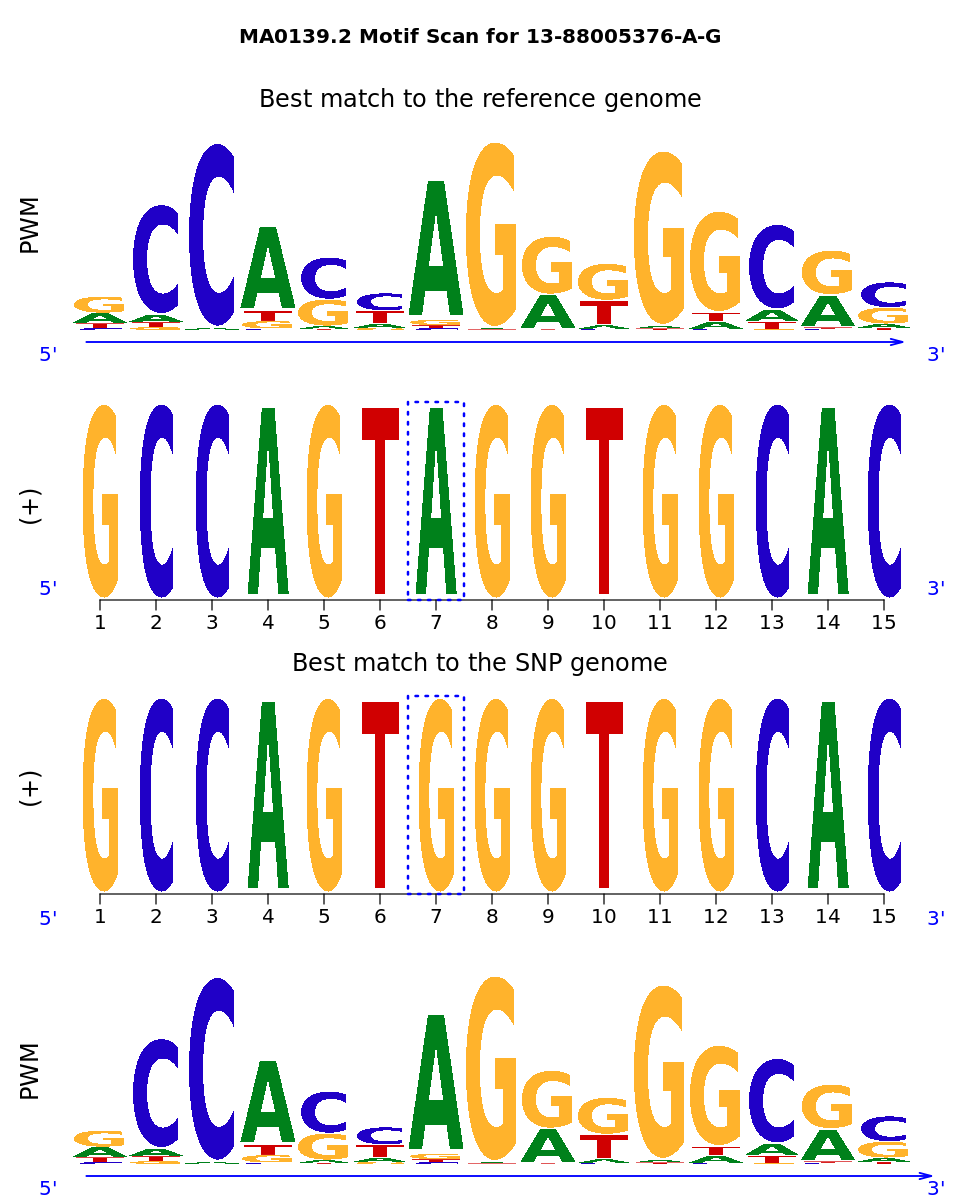

In [5]:
# ------------- #
# LoB           #
# ------------- #

JASPAR_PFM <- "config/MA0139.2-pfm.txt"
REF_FASTA <- "results/figures/atsnp/ref_lob.fasta"
ALT_FASTA <- "results/figures/atsnp/alt_lob.fasta"

print("Running...")

# Load PFM with pseudocounts
pwm <- LoadMotifLibrary(JASPAR_PFM, tag = ">", skiprows = 1, skipcols = 1, transpose = TRUE, 
 field = 1, sep = c("\t", " ", "\\[", "\\]", ">"),
 pseudocount = 1)

print("Read in PWM.")

# Read in snp - NOTE DEFAULT PAR
snp_info <- LoadFastaData(REF_FASTA, ALT_FASTA, default.par = FALSE)

print("Loaded fasta.")


# Calculate scores
atsnp.scores <- ComputeMotifScore(pwm, snp_info, ncores = 8)

# Pvalues and results #NOTE: TESTTING.MC=FALSE
atsnp.result <- ComputePValues(motif.lib = pwm, snp.info = snp_info,
                    motif.scores = atsnp.scores$motif.scores, ncores = 8, testing.mc=FALSE)

pwm <- LoadMotifLibrary(JASPAR_PFM, tag = ">", skiprows = 1, skipcols = 1, transpose = TRUE, 
 field = 1, sep = c("\t", " ", "\\[", "\\]", ">"),
 pseudocount = 0)

match.seq<-dtMotifMatch(atsnp.scores$snp.tbl, atsnp.scores$motif.scores, 
snpids="13-88005376-A-G", motifs="MA0139.2", motif.lib = pwm)

plotMotifMatch(match.seq,  motif.lib = pwm)

## Figure 2

### Fig 2A

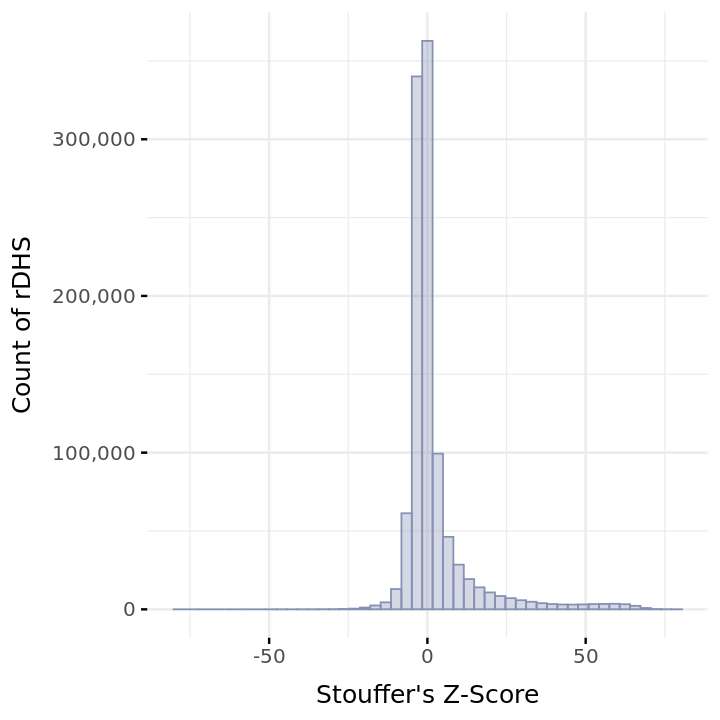

In [10]:
###
# Plotting
###

# Params
options(repr.plot.width=6, repr.plot.height=6)

F2A <- gghistogram(activity_anno,
    bins=50,
    x="zscore_meta_masked", 
    color=GENERAL_COLOR, 
    fill=GENERAL_COLOR, 
    alpha=0.35,
    ggtheme=theme_minimal(15),
    ylab="Count of rDHS",
    xlab="Stouffer's Z-Score",
) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),  
    axis.title.x = element_text(margin = margin(t = 10)), 
  ) +
  scale_y_continuous(labels = scales::comma) +
  scale_x_continuous(limits = c(-max(abs(activity_anno$zscore_meta_masked)), max(abs(activity_anno$zscore_meta_masked))))

# Call
F2A

### Fig 2B

`geom_smooth()` using formula = 'y ~ x'


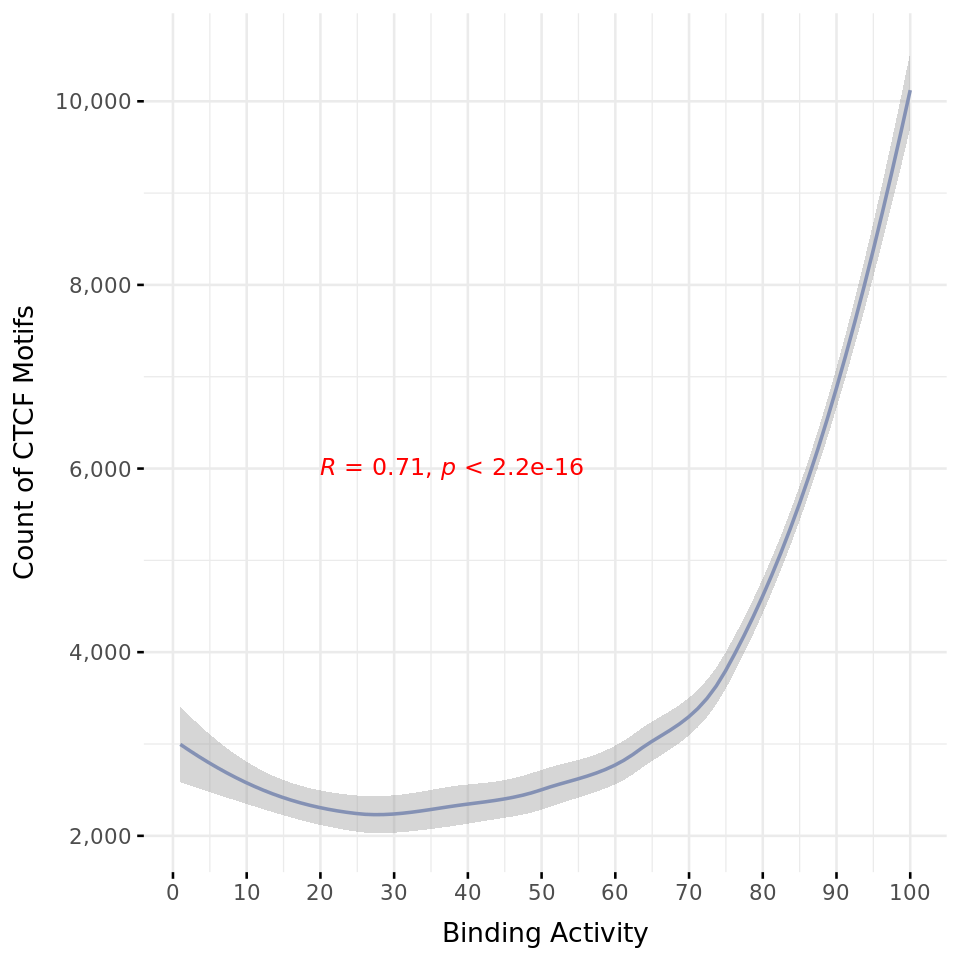

In [12]:
###
# Plot Data
###

motif_counts_by_rdhs <- vroom(MOTIF_COUNTS_BY_RDHS, col_names = FALSE, show_col_types = FALSE)
colnames(motif_counts_by_rdhs) <- c("rDHS", "mid_count")

# Merge with activity_anno
motif_counts_by_rdhs <- left_join(motif_counts_by_rdhs, activity_anno, by = c("rDHS"))

plot_data <- motif_counts_by_rdhs %>%
  group_by(activity_quantile) %>%
  summarise(nmid = sum(mid_count))

# Ensure dtypes as numeric
plot_data$activity_quantile <- as.numeric(plot_data$activity_quantile)
plot_data$nmid <- as.numeric(plot_data$nmid)

###
# Plotting
###

# Params
options(repr.plot.width = 8, repr.plot.height = 8)

# Smooth curve where x = activity_quantile and y = nmid
F2B <- ggplot(plot_data, aes(x = activity_quantile, y = nmid)) +
  geom_smooth(method = "loess", color = GENERAL_COLOR) +
  scale_x_continuous(breaks = seq(0, 100, 10)) +
  scale_y_continuous(labels = scales::comma)


# Customize the plot
F2B <- ggpar(F2B, 
  xlab = "Binding Activity Quantile",
  ylab = "Count of CTCF Motifs",
  ggtheme = theme_minimal(16),
) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),  # Add space to the right of the y-axis label
    axis.title.x = element_text(margin = margin(t = 10)),  # Add space to the right of the y-axis label
  ) +
  stat_cor(
    method = "pearson", 
    color = 'red', 
    size = 5, 
    label.y = 6000, 
    label.x = 20, 
    label.sep = ", "
  )


# Display the plot
F2B

### Fig 2C

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


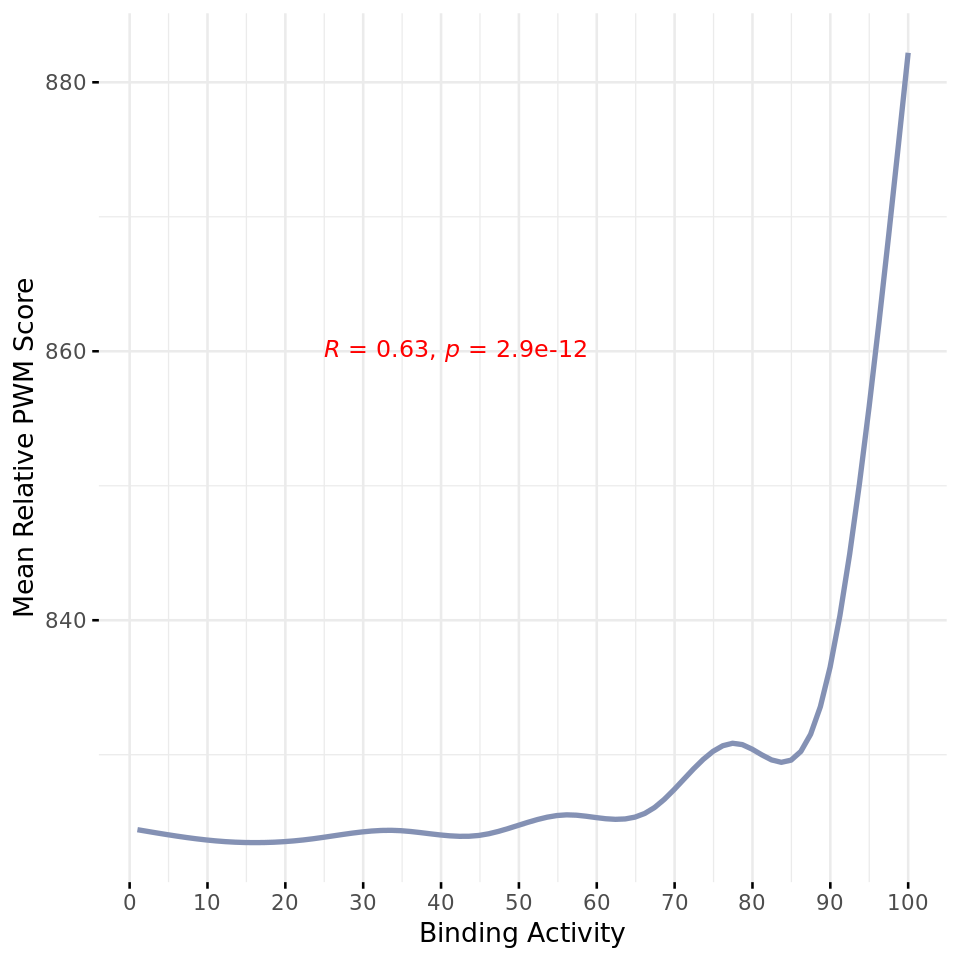

In [13]:
###
# Plot data
###

# Groupby by zscore_meta_masked_norm_quantile and calculate the mean and se
plot_data <- matrix[!duplicated(matrix$mid),] %>% 
  select(mid, activity_quantile, rel_pwm) %>% 
  group_by(activity_quantile) %>%
  summarize(
    mean_pwm = mean(rel_pwm), 
    se_mean_pwm = sd(rel_pwm) / sqrt(n()),
    n = n()
  )

###
# Plotting
###

# Params
options(repr.plot.width = 8, repr.plot.height = 8)

# Create the plot
F2C <- ggplot(plot_data, aes(x = activity_quantile, y = mean_pwm)) +
  geom_smooth(method = 'gam', color = GENERAL_COLOR, linewidth = 1.5, se = FALSE) + 
  scale_x_continuous(breaks = seq(0, 100, 10))

# Customize the plot
F2C <- ggpar(F2C, 
  xlab = "Binding Activity Quantile",
  ylab = "Mean Relative PWM Score",
  ggtheme = theme_minimal(16),
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),  # Add space to the right of the y-axis label
    axis.title.x = element_text(margin = margin(t = 10)),  # Add space to the right of the y-axis label
  )
 ) +
stat_cor(
    method = "pearson", 
    color = 'red', 
    size = 5, 
    label.y = 860, 
    label.x = 25, 
    label.sep = ", ",
  )

# Display the plot
F2C

### Fig 2D

`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can

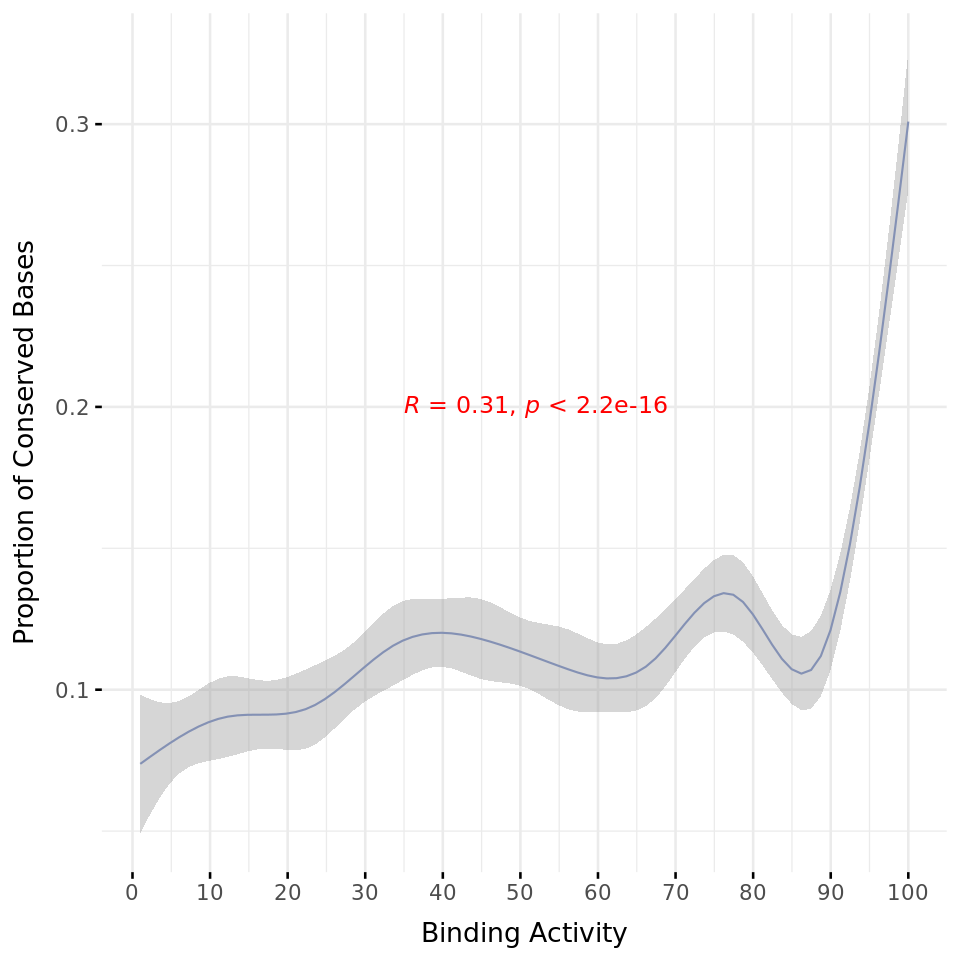

In [15]:
###
# Plot data
###

# Select zscore_meta_masked_norm_quantile, linsight, gerp++, phlyoP100, phastcons100
plot_data <- matrix %>% 
  select(activity_quantile, linsight, `gerp++`, phylop100, phastcons100)

# Pivor to long format
plot_data <- plot_data %>% 
  pivot_longer(cols = c(linsight, `gerp++`, phylop100, phastcons100), names_to = "metric", values_to = "value")

# Conserved thresholds
gerp_threshold <- 2
linsight_threshold <- 0.8
phastcons_threshold <- 0.8
phylop100_threshold <- 1

# Initialize an empty list to store the data frames
list_of_data_frames <- list()

# Repeat the operation 10 times
set.seed(123)
for (i in 1:10) {
  # Sample with replacement
  #sampled_data <- plot_data %>% sample_n(nrow(plot_data), replace = TRUE)
  sampled_data <- plot_data %>% sample_n(10000, replace = TRUE)
  
  # Add the 'conserved' column
  sampled_data <- sampled_data %>% 
    mutate(conserved = case_when(
      metric == "linsight" & value >= linsight_threshold ~ 1,
      metric == "gerp++" & value >= gerp_threshold ~ 1,
      metric == "phylop100" & value >= phylop100_threshold ~ 1,
      metric == "phastcons100" & value >= phastcons_threshold ~ 1,
      TRUE ~ 0
    ))

  # Groupby by zscore_meta_masked_norm_quantile, metric and calculate proportion of conserved
  sampled_data <- sampled_data %>% 
    group_by(activity_quantile, metric) %>% 
    summarize(prop_conserved = sum(conserved) / n())
  
  # Add the sampled data to the list
  list_of_data_frames[[i]] <- sampled_data
}

# Combine all data frames in the list into a single data frame in long format
all_data_long <- bind_rows(list_of_data_frames)

###
# Plotting
###

# Params
options(repr.plot.width = 8, repr.plot.height = 8)

# Create the plot
F2D <- ggplot(all_data_long %>% 
                filter(metric == "phylop100"), 
              aes(x = activity_quantile, y = prop_conserved)) +
  geom_smooth(color = GENERAL_COLOR, size = 0.60) + 
  scale_x_continuous(breaks = seq(0, 100, 10))

# Customize the plot
F2D <- ggpar(F2D, 
  xlab = "Binding Activity Quantile",
  ylab = "Proportion of Conserved Bases",
  ggtheme = theme_minimal(16)
) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),  
    axis.title.x = element_text(margin = margin(t = 10))
  ) +
  stat_cor(method = "pearson", color = 'red', size = 5, label.y = 0.20, label.x = 35)

# Display the plot
F2D

## Figure 2 Mock-Up

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


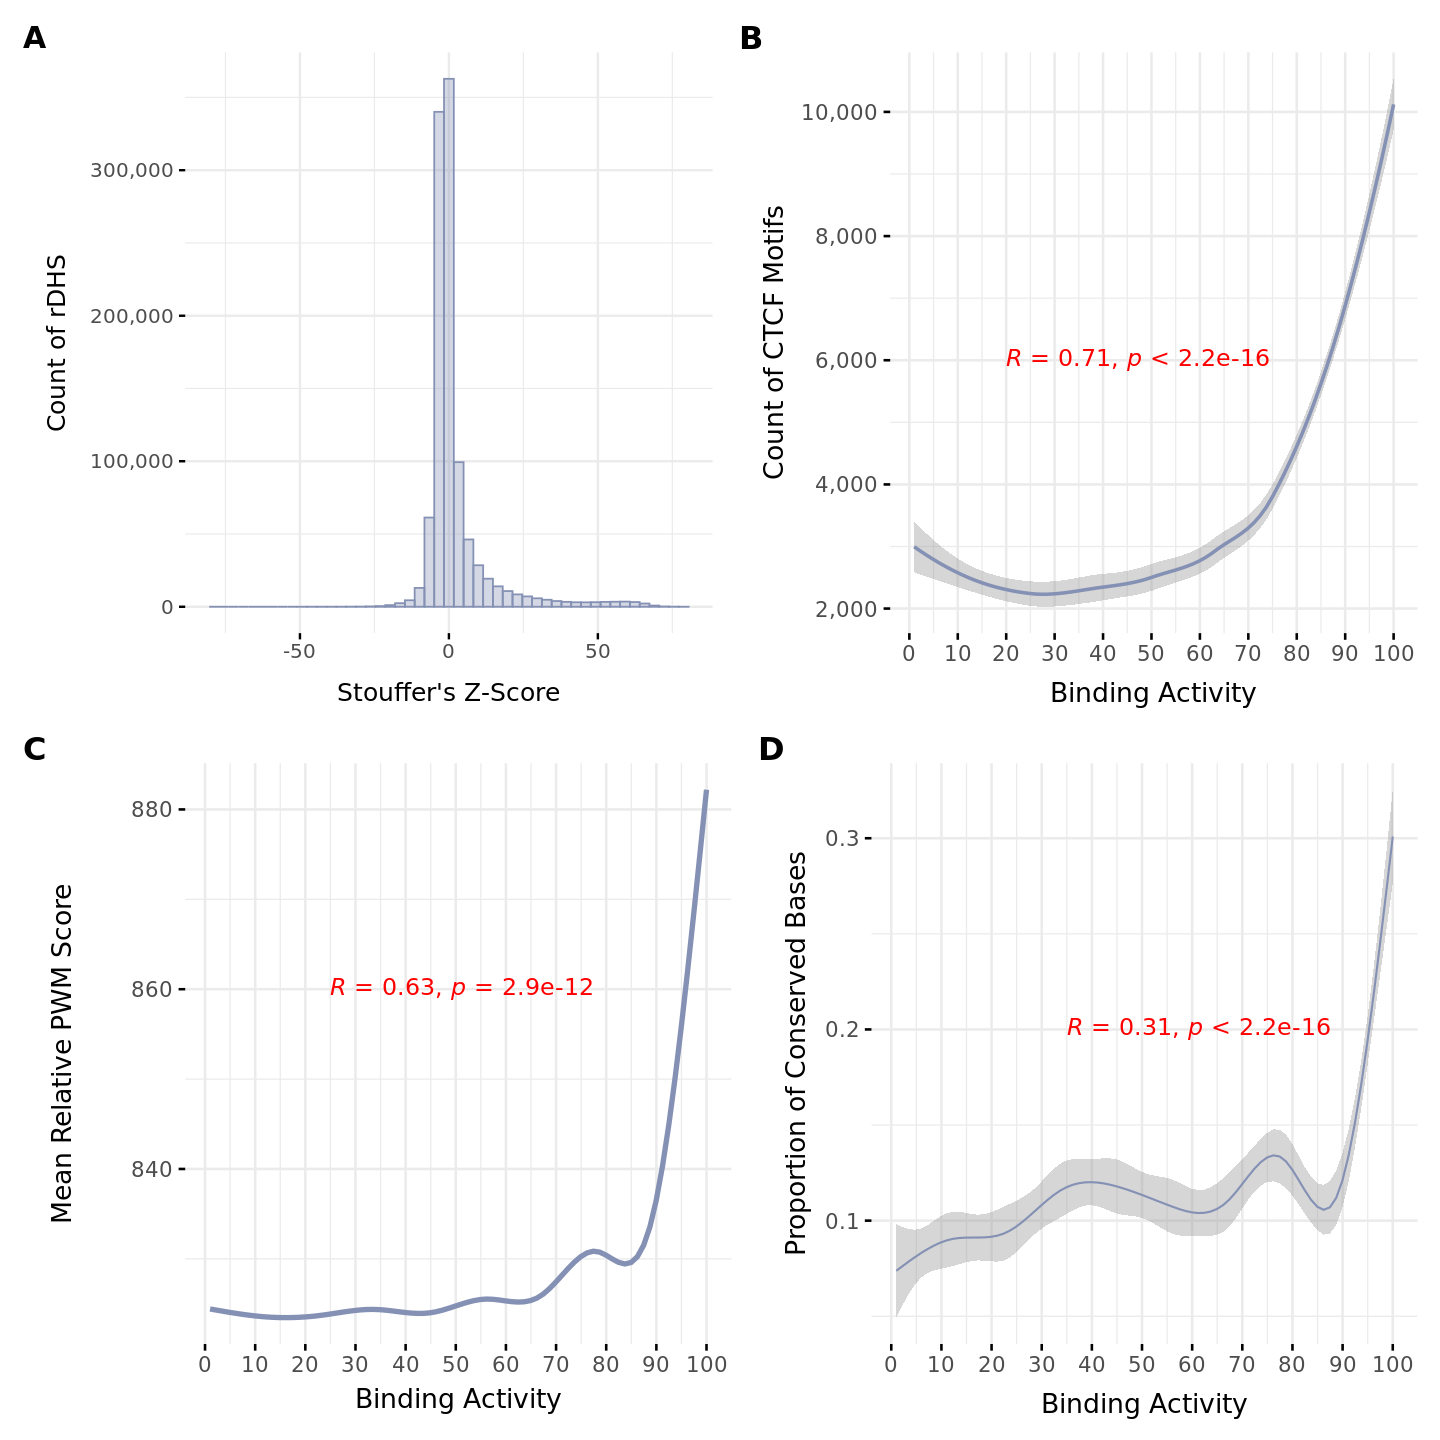

In [16]:
###
# Call
###

# Params
width <- 12
height <- 12
figname <- paste(MAIN_FIGURE_DIR, "F2.png", sep = "/")
options(repr.plot.width=width, repr.plot.height=height)

# Call
((F2A | F2B) / (F2C | F2D)) + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(face = "bold"))

# Save figure, 300 dpi
ggsave(figname, width = width, height = height, dpi = 300)

## Figure 3

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”
Warning message:
“Removed 115253 rows containing non-finite values (`stat_bin()`).”


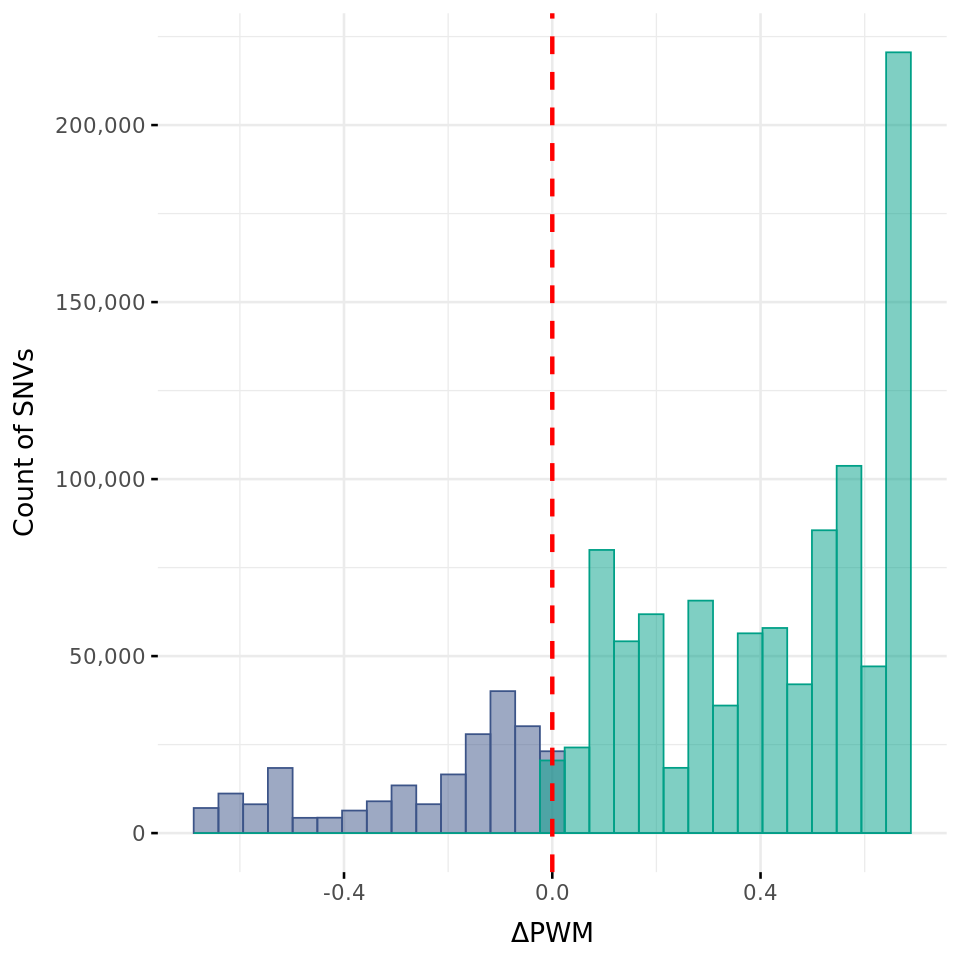

In [4]:
###
# Plotting
###

# Params
options(repr.plot.width=8, repr.plot.height=8)

F3A <- gghistogram(matrix %>% filter(vid != "NaN"), x = "dpwm",
  color = 'dpwm_class',
  fill = 'dpwm_class',
  palette = c(GOB_COLOR_CODE, LOB_COLOR_CODE),
  alpha = 0.5,
  ggtheme = theme_minimal(16),
  ylab = "Count of SNVs", 
  xlab = "ΔPWM",
  xtick.angle = 90, 
  xlab.hjust = 1,
  xlab.vjust = 1, 
  xlab.size = 14,
  legend = "none",
  ylab.size = 14
) + 
geom_vline(xintercept = 0, linetype = "dashed", color = "red", size = 1.25) +
labs(fill = "dPWM Class") + 
guides(color = FALSE) +
scale_y_continuous(labels = scales::comma) +
theme(
  axis.title.y = element_text(margin = margin(r = 10)),
  axis.title.x = element_text(margin = margin(t = 10))
)

# Call
F3A

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


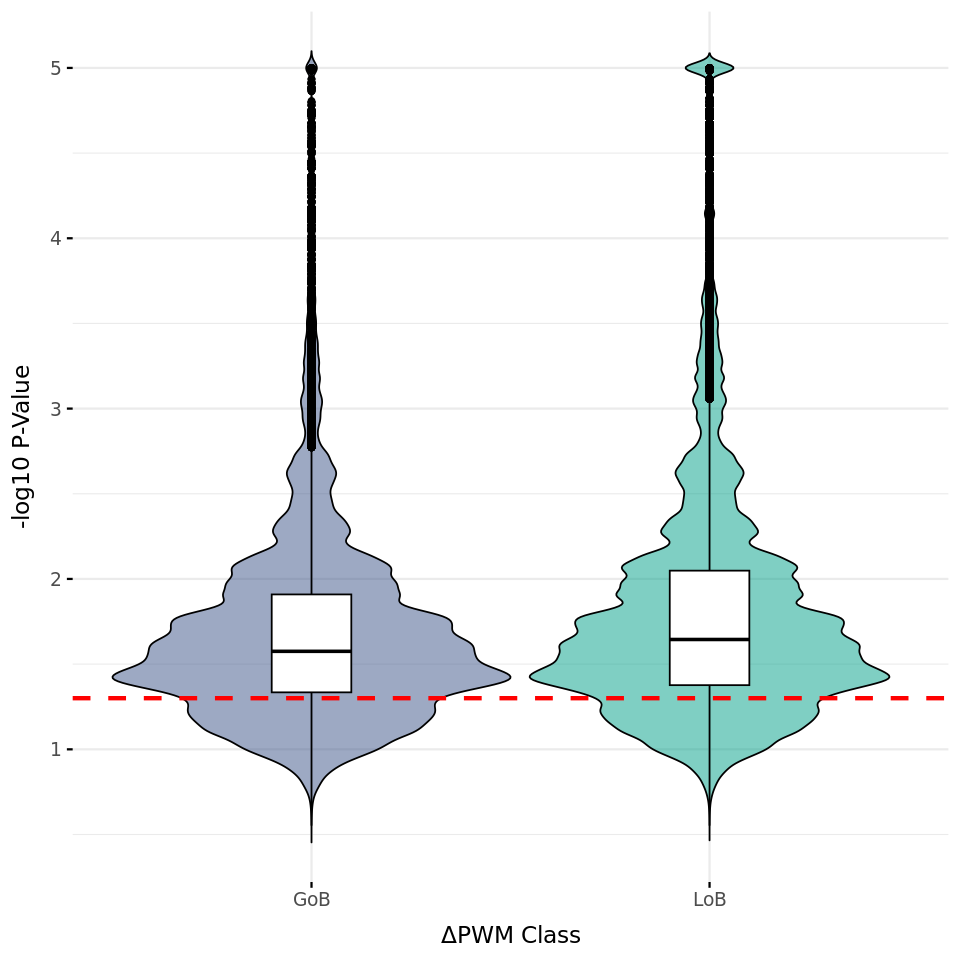

In [3]:
###
# Plot data
###

plot_data <- matrix %>% 
  filter(!is.nan(ref_pwm_pval_log10)) %>%
  select(dpwm_class, ref_pwm_pval_log10)

# Cap p-values at 4
plot_data$ref_pwm_pval_log10 <- pmin(plot_data$ref_pwm_pval_log10, 5)
plot_data$dpwm_class <- factor(plot_data$dpwm_class, levels = c("GoB", "LoB"))

###
# Plotting
###

# Params
options(repr.plot.width=8, repr.plot.height=8)


F3B <- ggviolin(plot_data,
   x = "dpwm_class",
   y = "ref_pwm_pval_log10",
   fill = 'dpwm_class',
   alpha = 0.5,
   ggtheme = theme_minimal(14),
   ylab = "-log10 P-Value", 
   xlab = "ΔPWM Class",
   xtick.angle=90, 
   xlab.hjust = 1,
   xlab.vjust = 1, 
   xlab.size = 14, 
   ylab.size = 14,
  legend = "none",
   add = "boxplot",
    add.params = list(fill = "white")) + 
   labs(fill = "ΔPWM Class") + 
   scale_fill_manual(values = c("LoB" = LOB_COLOR_CODE, "GoB" = GOB_COLOR_CODE)) +
   geom_hline(yintercept = 1.3, linetype = "dashed", color = "red", size=1.25) +
theme(
  axis.title.y = element_text(margin = margin(r = 10)),
  axis.title.x = element_text(margin = margin(t = 10))
)

# Call
F3B

`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.


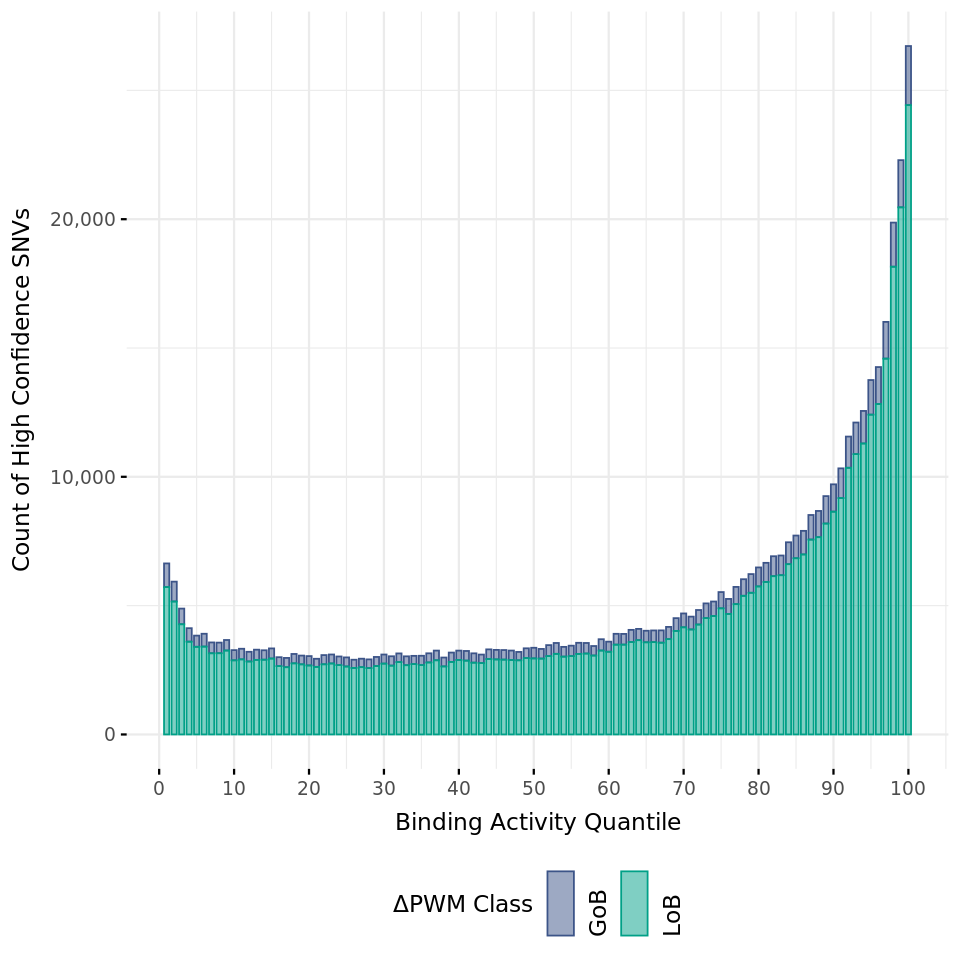

In [5]:
###
# Plot data
###

plot_data <- matrix %>% 
    select(activity_quantile, vid, dpwm_class, pwm_stat_class) %>%
    filter(vid != "NaN" & dpwm_class != "NA" & pwm_stat_class != "NA")

# Count of high impact SNVs in each activity bin by dpwm class
plot_data <- plot_data %>% 
    group_by(activity_quantile, dpwm_class, pwm_stat_class) %>%
    summarize(num_vids = n_distinct(vid))

# Subset to only high confidence
plot_data <- plot_data %>% 
    filter(pwm_stat_class == 1)

# Ensure dpwm_class is factor for plotting
plot_data$pwm_stat_class <- factor(plot_data$pwm_stat_class)

###
# Plotting
###

options(repr.plot.width=8, repr.plot.height=8)


# Barplot, x = activity_quantile_mid, y = context_nvar, color = pwm_stat_class
F3C <- ggbarplot(
  plot_data, 
  x = "activity_quantile", 
  y = "num_vids", 
  color = "dpwm_class", 
  fill = "dpwm_class", 
  palette = c("LoB" = LOB_COLOR_CODE, "GoB" = GOB_COLOR_CODE), 
  alpha = 0.5,
  ggtheme = theme_minimal(14),
  ylab = "Count of High Confidence SNVs",
  xlab = "Binding Activity Quantile",
  legend.title = "ΔPWM Class",
  legend.title.align = 0.5,
  legend.title.fontface = "bold",
  legend.title.size = 10,
  legend.ticks.size = 10,
  legend = "bottom"
) +
  theme(
    legend.text = element_text(size = 14, angle = 90, margin = margin(t = 10)),
    axis.text.x = element_text(angle = 0, vjust = 0.5),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))
  ) + 
  scale_x_continuous(breaks = seq(0, 100, by = 10)) +
  scale_y_continuous(labels = scales::comma)

# Call
F3C

Warning message:
“Removed 115253 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 115253 rows containing non-finite values (`stat_bin()`).”


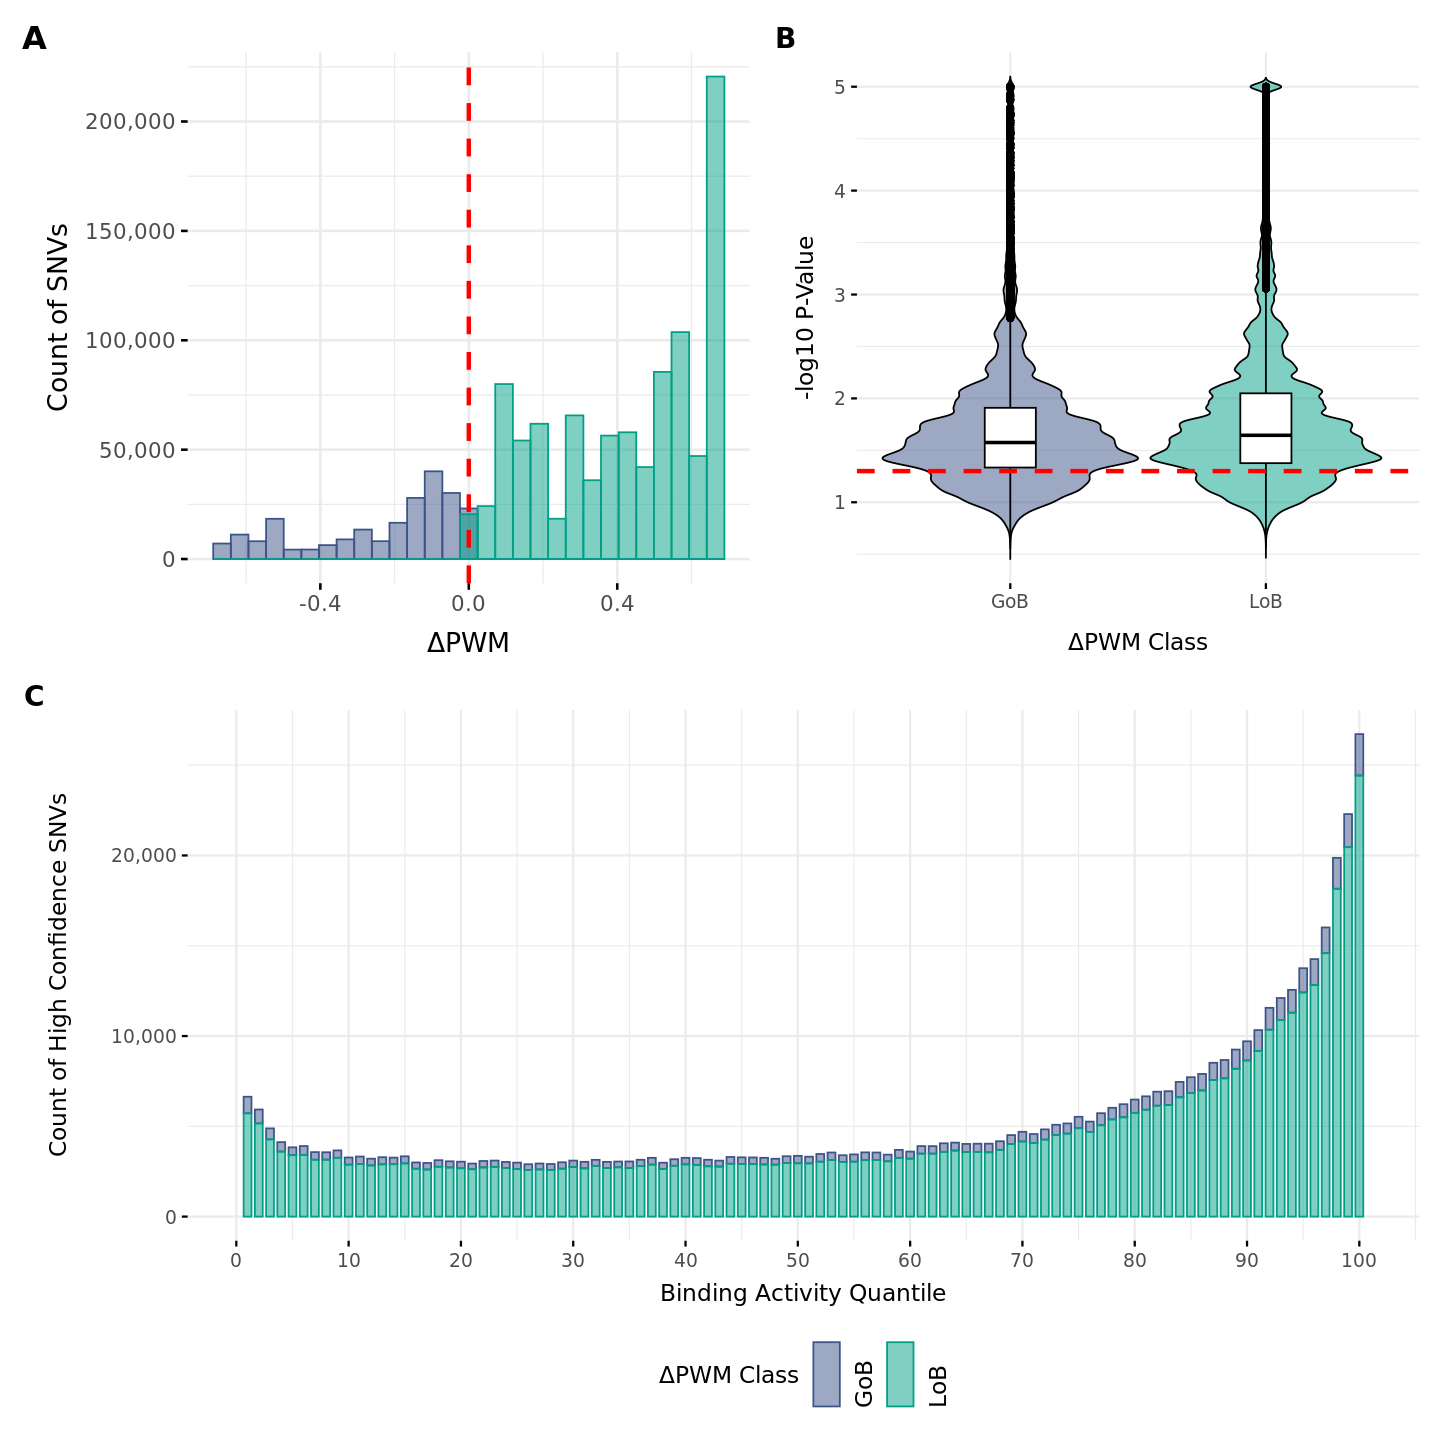

In [6]:
###
# Call
###

# Params
width <- 12
height <- 12
figname <- paste(MAIN_FIGURE_DIR, "F3.png", sep = "/")
options(repr.plot.width=width, repr.plot.height=height)

# Call
((F3A | F3B) / F3C) + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(face = "bold"))

# Save figure, 300 dpi
ggsave(figname, width = width, height = height, dpi = 300)

In [50]:
# Write out matrix subset for maps
subset <- matrix %>% 
  select(vid, ac, ref, alt, context, activity_quantile_mid, dpwm_class, pwm_stat_class, isvar, singleton) %>%
  filter(vid != "NaN" & dpwm_class != "NaN" & pwm_stat_class != "NaN")

# Write out
write_tsv(subset, "results/figures/matrix-subset.for_maps.tsv")

## Figure 4

In [18]:
###
# Plot Data
###

# Initialize an empty list to store the data frames
list_of_data_frames <- list()

# Repeat the operation 10 times
set.seed(123)
for (i in 1:10) {
  # Subset and Sample with replacement
  plot_data <- matrix %>% 
    filter(vid != "NaN" & !is.na(caddPhred) & dpwm_class != "NaN") %>%
    select(vid, activity_quantile, caddPhred, dpwm, dpwm_class, pwm_stat_class) %>%
    sample_n(10000, replace = TRUE)

  # Flag pathogenic if caddPhred >= 10
  plot_data <- plot_data %>% 
    mutate(pathogenic = ifelse(caddPhred >= 10, 1, 0))

  # Group by activity_quantile, dpwm_class, and pwm_stat_class, then calculate proportion of pathogenic
  plot_data <- plot_data %>% 
    group_by(activity_quantile, dpwm_class, pwm_stat_class) %>% 
    summarize(
      prop_pathogenic = sum(pathogenic) / n(),
      n = n()
    )

  # Add the sampled data to the list
  list_of_data_frames[[i]] <- plot_data
}

# Combine all data frames in the list into a single data frame in long format
all_data_long <- bind_rows(list_of_data_frames)

# Confirm factor
all_data_long$dpwm_class <- factor(all_data_long$dpwm_class)

# Replace pwm_stat_class: 1 = sig, 0 = not sig
all_data_long <- all_data_long %>% 
  mutate(pwm_stat_class = ifelse(pwm_stat_class == 1, "Yes", "No"))
all_data_long$pwm_stat_class <- factor(all_data_long$pwm_stat_class)

`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile',

### Fig 4A

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


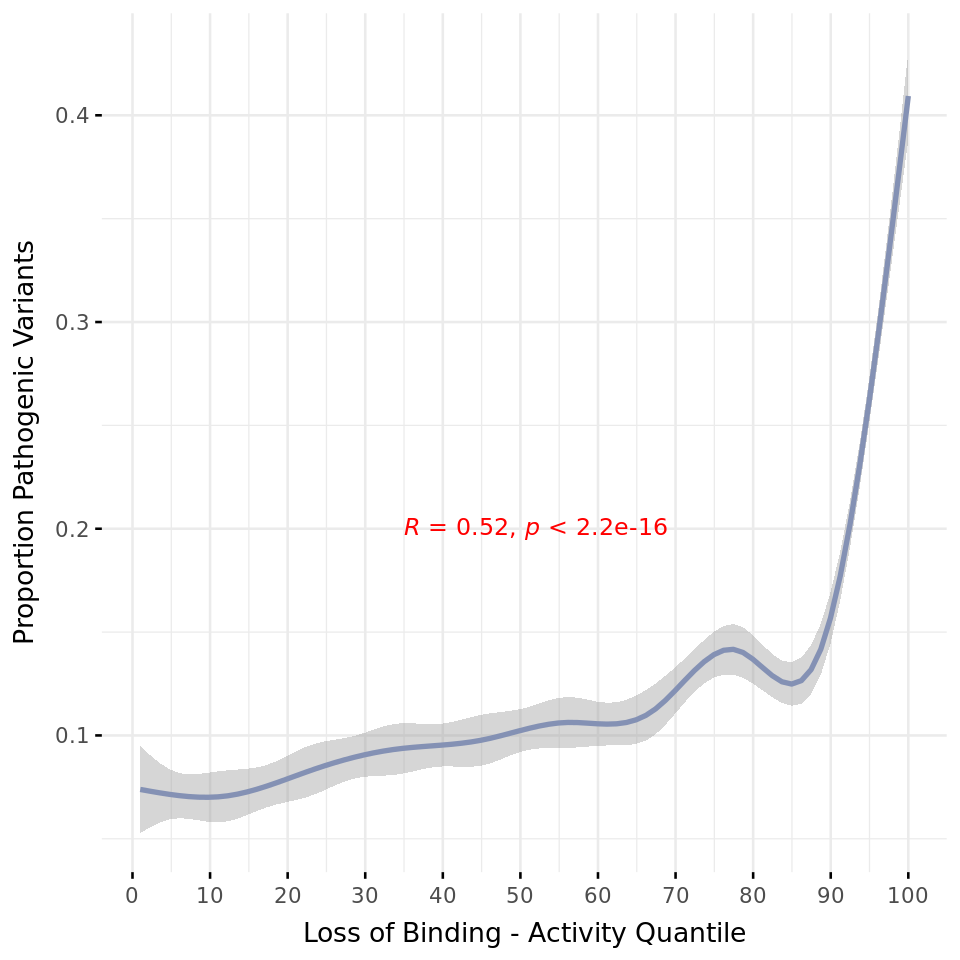

In [22]:
###
# Plot data
###

plot_data <- all_data_long %>% filter(dpwm_class=="LoB" & pwm_stat_class=="Yes")

###
# Plotting
###

options(repr.plot.width=8, repr.plot.height=8)

#
F4A <- ggplot(plot_data, 
  aes(x = activity_quantile, y = prop_pathogenic)) +
  geom_smooth(size=0.60, color=GENERAL_COLOR, linewidth=1.5) +
  scale_x_continuous(breaks = seq(0, 100, 10))

#
F4A <- ggpar(F4A, 
  xlab = "Loss of Binding - Activity Quantile",
  ylab = "Proportion Pathogenic Variants",
  ggtheme = theme_minimal(16)
) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10)), 
    axis.title.x = element_text(margin = margin(t = 10)),
    axis.text.x = element_text(angle = 00, vjust = 0.5)) +
  stat_cor(method = "pearson", color = 'red', size = 5, label.y = 0.20, label.x = 35)



# Call
F4A

### F4B

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


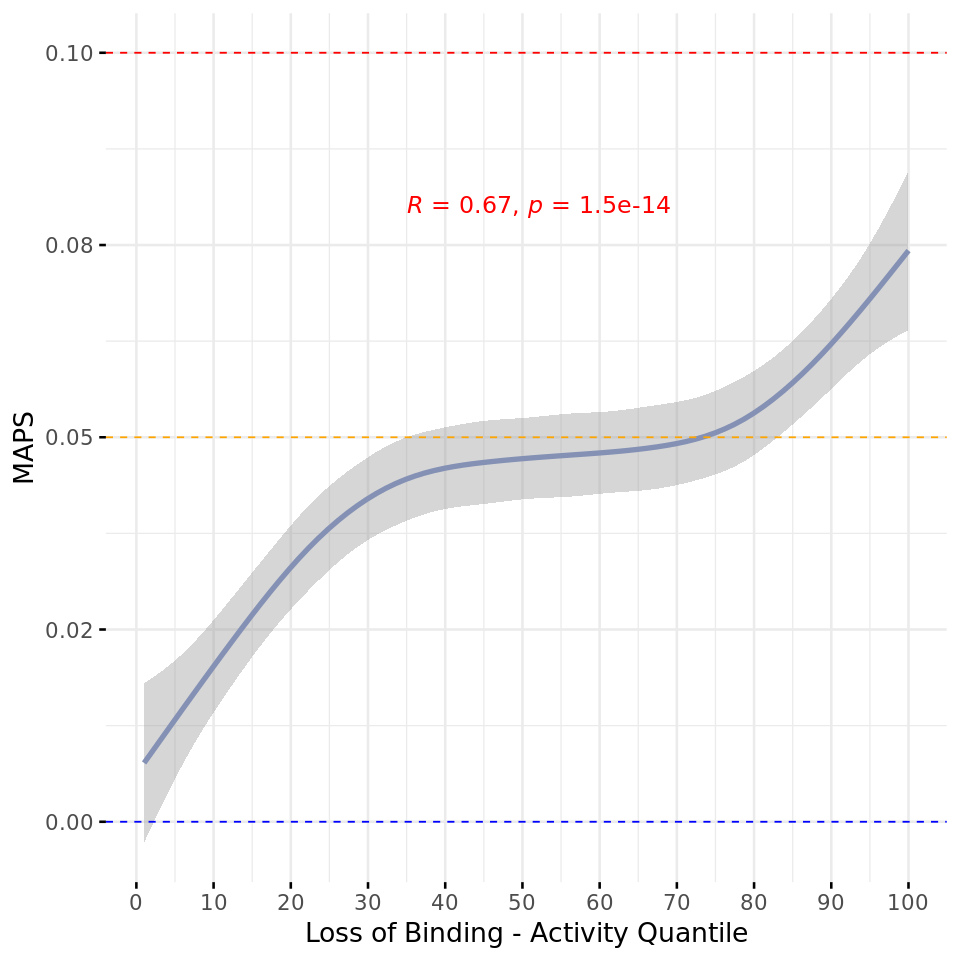

In [23]:
###
# Plot data
###

# Read in maps
maps <- vroom("results/figures/all_maps.tsv", show_col_types=FALSE)

# Confirm factors
maps <- maps %>% 
  mutate(pwm_stat_class = ifelse(pwm_stat_class == 1, "Yes", "No"))
maps$pwm_stat_class <- factor(maps$pwm_stat_class)

###
# Plot data
###

plot_data <- maps %>% filter(dpwm_class=="LoB" & pwm_stat_class=="Yes")

###
# Plotting
###

options(repr.plot.width=8, repr.plot.height=8)

F4B <- ggplot(plot_data,
   aes(x = activity_quantile_mid, y = maps)) +
  geom_smooth(color=GENERAL_COLOR, method='gam', size=1.5, linewidth=1.5) +
  geom_hline(yintercept = 0,  color='blue', linetype = "dashed") + 
  geom_hline(yintercept = 0.05, color='orange', linetype = "dashed") +
  geom_hline(yintercept = 0.1, color='red', linetype = "dashed") +
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))
  ) +
  stat_cor(method = "pearson", color = 'red', size = 5, label.y = 0.08, label.x = 35) +
  scale_x_continuous(breaks = seq(0, 100, 10)) +
  scale_y_continuous(labels = scales::number_format(accuracy = 0.01))


F4B <- ggpar(F4B, 
  xlab = "Loss of Binding - Activity Quantile",
  ylab = "MAPS",
  ggtheme = theme_minimal(16)
)

# Call
F4B

### Figure 4 mockup

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


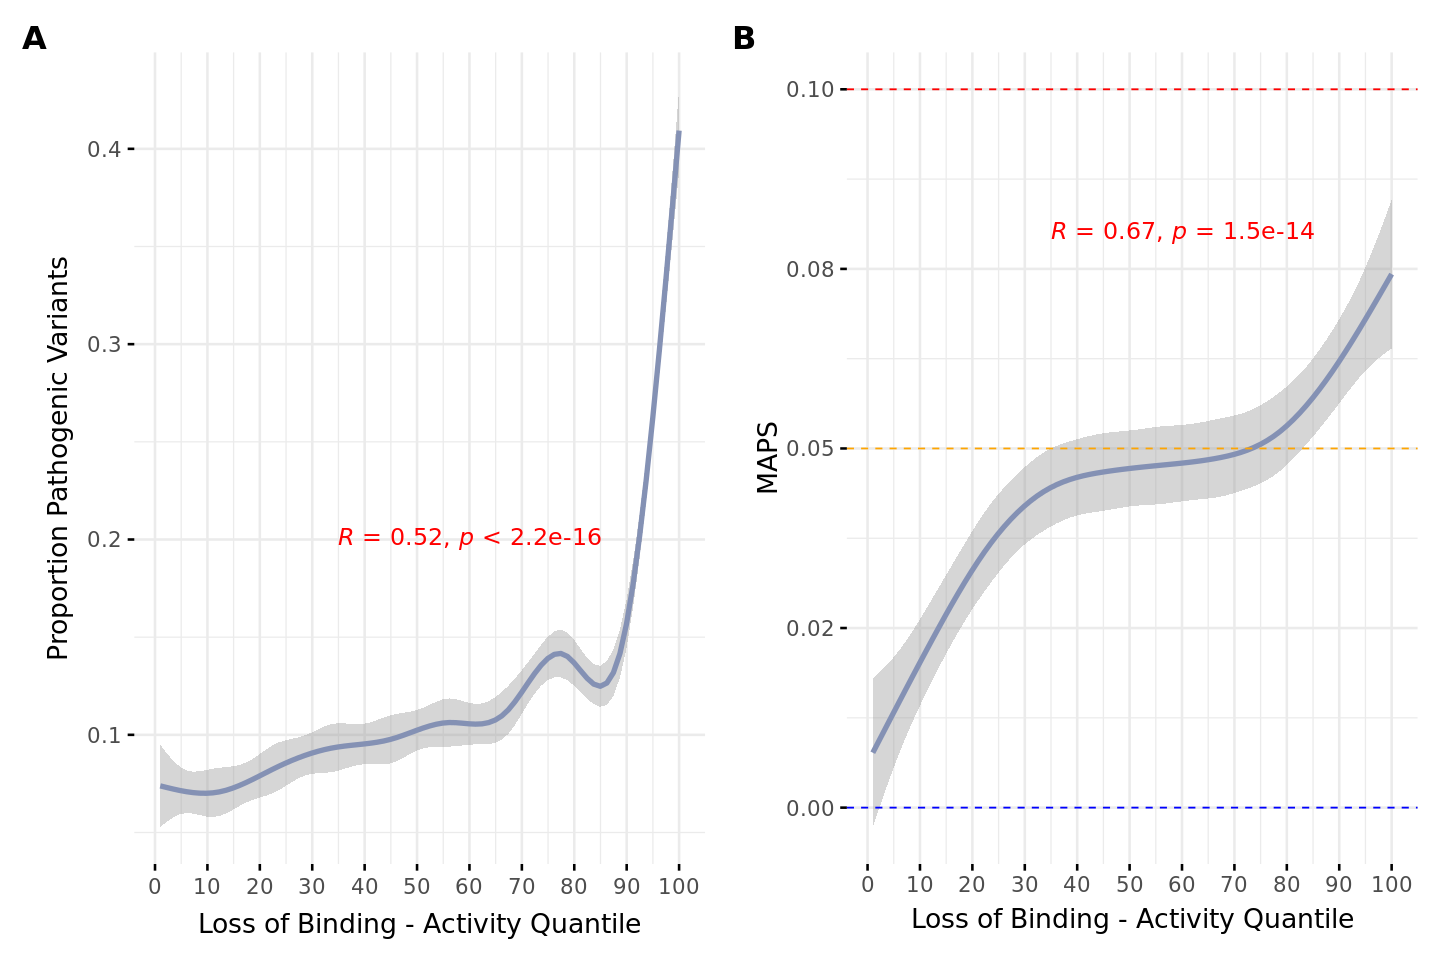

In [24]:
###
# Call
###

# Params
width <- 12
height <- 8
figname <- paste(MAIN_FIGURE_DIR, "F4.png", sep = "/")
options(repr.plot.width=width, repr.plot.height=height)

# Call
(F4A | F4B) + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(face = "bold"))

# Save figure, 300 dpi
ggsave(figname, width = width, height = height, dpi = 300)

# Supplementary Tables

In [25]:
# Need this here as a workaround to show table 
gts <- function(gt_table){
   gt:::as.tags.gt_tbl(gt_table)
}

## Supplementary Table 1

In [27]:
ccre_anno <- "results/01_Annotate-rDHS/GRCh38-cCRES.CTCF_signal.activity.tsv"
ccre_anno <- vroom(ccre_anno, show_col_types=FALSE)

# Summarize cCRE data
table_data_ccre <- ccre_anno %>% 
  mutate(length = pos1 - pos0) %>%
  summarize(
  Annotation = "rDHS", 
      `N` = n(), 
      `Length (bp)` = round(mean(length)), 
      `Footprint (Mb)` = round(sum(length) / 1e6),
      `Coverage Conservation` = "--", 
      `Coverage CADD` = "--", 
      `Number SNVs` = "--"
)
# Summarize cCRE + PWM
annotation <- "rDHS + PWM"
N <- 355418
length <- 15
footprint <- round((N * length) / 1e6)
conservation <- 100
cadd <- round(1253330 / (N * length), 2)
snvs <- 1253330

# Create table using dplyr
table_data_pwm <- data.frame(
  Annotation = annotation, 
  `N` = N, 
  `Length (bp)` = length, 
  `Footprint (Mb)` = footprint, 
  `Coverage Conservation` = conservation, 
  `Coverage CADD` = cadd, 
  `Number SNVs` = snvs
)
colnames(table_data_pwm) <- c("Annotation", "N", "Length (bp)", "Footprint (Mb)", "Coverage Conservation", "Coverage CADD", "Number SNVs")


# combine tables
table_data <- rbind(table_data_ccre, table_data_pwm)


table <- gt(table_data) |>
  tab_header(
    title = "Supplementary Table 1"
  ) |>
  opt_stylize(style = 6, color = 'gray') |>
  tab_style(
    style = cell_text(weight = "bold"),
    locations = cells_body(columns = vars(`Annotation`))
  )

#
table |>
  gts()

# Save the table as an image file
# figname <- paste(SUPP_FIGURE_DIR, "T01.png", sep = "/")
# gtsave(table, figname)

ERROR: Error in tab_style(opt_stylize(tab_header(gt(table_data), title = "Supplementary Table 1"), : could not find function "tab_style"


## Supplementary Table 2

In [3]:
MAPS_DIR <- "/data/ruderferlab/projects/biovu/cnv/cre/CTCF-Variant-Annotation/snakemake/workflows/projects/deltaActivity/results/gnomad/maps/class"

# Read in all results (.tsv) and combine into matrix
maps <- list.files(MAPS_DIR, pattern = "\\.tsv$", full.names = TRUE) %>%
  map_dfr(~read_tsv(.x) %>% 
            mutate(file = basename(.x)))

# Split the file field entires that look like maps-splice_acceptor_variant.tsv into just splice_acceptor_variant

maps <- maps %>% 
mutate(file = str_remove(file, "maps-")) %>%
mutate(file = str_remove(file, ".tsv"))

# Subset to fields
maps <- maps %>% 
  select(file, variant_count, maps, sem)

Rows: 1 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (6): singleton_count, expected_singelton_count, variant_count, ps, maps,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (6): singleton_count, expected_singelton_count, variant_count, ps, maps,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (6): singleton_count, expected_singelton_count, variant_count, ps, maps,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or

In [4]:
maps

file,variant_count,maps,sem
<chr>,<dbl>,<dbl>,<dbl>
3_prime_UTR_variant,10000000,0.02753848,0.0001580800
5_prime_UTR_variant,9442976,0.05580984,0.0001626839
intergenic_variant,19999998,0.02855642,0.0001118019
missense_variant,6075537,0.04350975,0.0002028029
splice_acceptor_variant,82838,0.12561471,0.0016946894
splice_donor_variant,112806,0.09645091,0.0014729304
start_lost,26198,0.09852814,0.0030483247
stop_gained,201570,0.11960173,0.0011068252
stop_lost,12784,0.11222954,0.0043209283


In [32]:
MAPS_DIR <- "/data/ruderferlab/projects/biovu/cnv/cre/CTCF-Variant-Annotation/snakemake/workflows/projects/deltaActivity/results/gnomad/maps/class"

# Read in all results (.tsv) and combine into matrix
maps <- list.files(MAPS_DIR, pattern = "\\.tsv$", full.names = TRUE) %>%
  map_dfr(~read_tsv(.x) %>% 
            mutate(file = basename(.x)))

# Split the file field entires that look like maps-splice_acceptor_variant.tsv into just splice_acceptor_variant

maps <- maps %>% 
mutate(file = str_remove(file, "maps-")) %>%
mutate(file = str_remove(file, ".tsv"))

# Subset to fields
maps <- maps %>% 
  select(file, variant_count, maps, sem)

# Rename cols
colnames(maps) <- c("Variant Class", "N", "MAPS", "SEM")

# Round decimals to 4 places
maps$MAPS <- round(maps$MAPS, 4)
maps$SEM <- round(maps$SEM, 4)

# Rename Variant class
maps$`Variant Class` <- c("3'UTR", "5'UTR", "Intergenic", "Missense", "Splice Acceptor", "Splice Donor", 
"Start Lost", "Stop Gained", "Stop Lost", "Synonymous")

# Sort by MAPS ascending
maps <- maps %>% 
  arrange(MAPS)

gt(maps) |>
  tab_header(
    title = "Supplementary Table 2"
  ) |>
  opt_stylize(style = 6, color = 'gray') |>
  tab_style(
    style = cell_text(weight = "bold"),
    locations = cells_body(columns = vars(`Variant Class`))
  ) |>
  gts()

Rows: 1 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (6): singleton_count, expected_singelton_count, variant_count, ps, maps,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (6): singleton_count, expected_singelton_count, variant_count, ps, maps,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (6): singleton_count, expected_singelton_count, variant_count, ps, maps,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or

Shiny tags cannot be represented in plain text (need html)

# Supplementary Figures

## Suplement Fig 1

### S1A

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


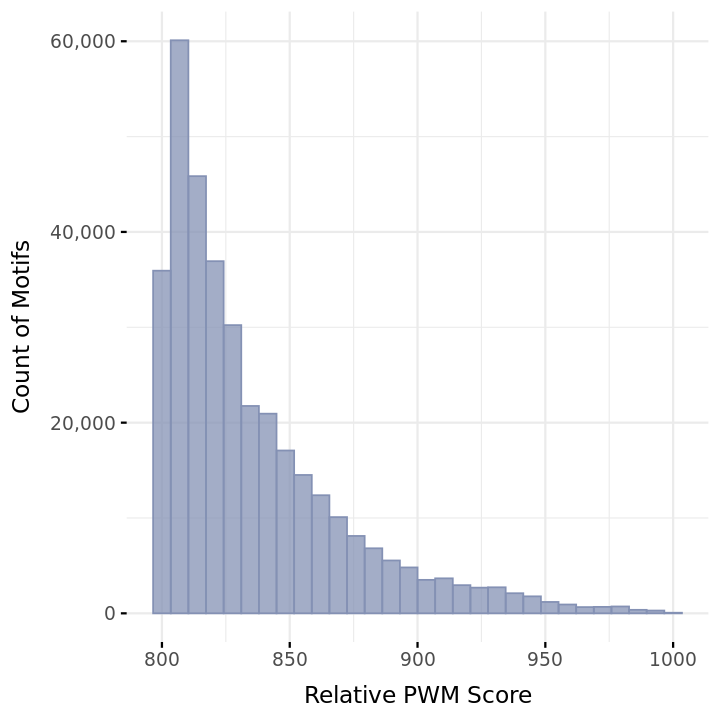

In [12]:
###
# Plotting
###

# Params
options(repr.plot.width=6, repr.plot.height=6)

S1A <- gghistogram(matrix[!duplicated(matrix$mid),], 
    x="rel_pwm", 
    color=GENERAL_COLOR, 
    fill=GENERAL_COLOR, 
    alpha=0.75,
    ggtheme=theme_minimal(14),
    ylab="Count of Motifs",
    xlab="Relative PWM Score",
) +
scale_y_continuous(labels = scales::comma) +
 theme(
    axis.title.y = element_text(margin = margin(r = 10)),  
    axis.title.x = element_text(margin = margin(t = 10)))

# Call
S1A

### S1B

In [27]:
motif_counts_by_rdhs %>% 
  group_by(ctcf_bound, mid_count_flag) %>%
  summarise(n = n(),
            prop = n()/nrow(motif_counts_by_rdhs))

`summarise()` has grouped output by 'ctcf_bound'. You can override using the
`.groups` argument.


ctcf_bound,mid_count_flag,n,prop
<chr>,<chr>,<int>,<dbl>
NoCTCFBound,CTCF-Neg,489233,0.4598582
NoCTCFBound,CTCF-Pos,124004,0.1165585
YesCTCFBound,CTCF-Neg,283852,0.2668088
YesCTCFBound,CTCF-Pos,166789,0.1567746


In [42]:
0.4598582 + 0.2668088

[1] 0.726667

Rows: 1063878 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): X4, X6

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'ctcf_bound'. You can override using the
`.groups` argument.


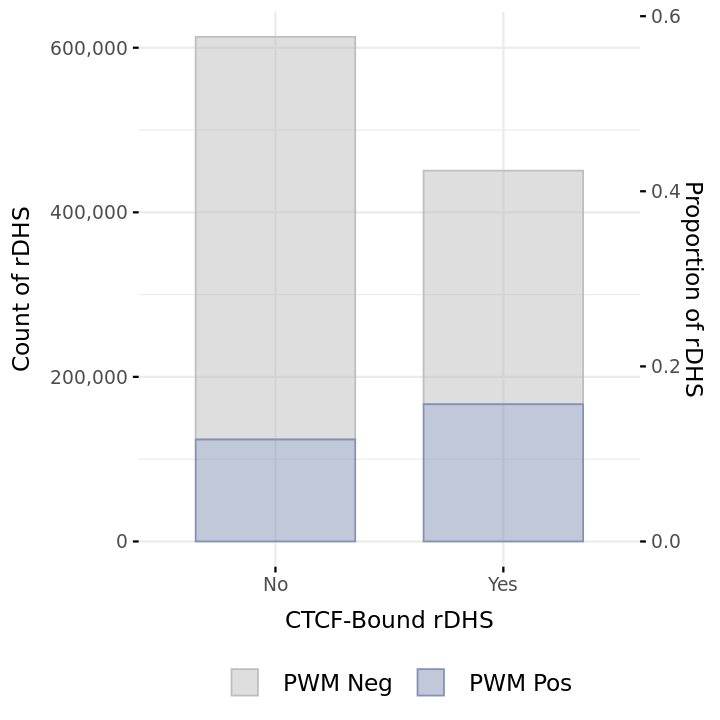

In [13]:
###
# Plot data
###

motif_counts_by_rdhs <- vroom(MOTIF_COUNTS_BY_RDHS, col_names = FALSE, show_col_types = FALSE)
colnames(motif_counts_by_rdhs) <- c("rDHS", "mid_count")

raw_ccres <- read_tsv(RAW_CCRES, col_names = FALSE, col_select = c(4,6)) %>%
  rename(rDHS = X4, ccre_description = X6)

# Flag if X6 contains "CTCF-bound"
raw_ccres$ctcf_bound <- ifelse(str_detect(raw_ccres$ccre_description, "CTCF-bound"), "Yes", "No")

# Merge motif_counts_by_rdhs with raw_ccres on rDHS
motif_counts_by_rdhs <- left_join(motif_counts_by_rdhs, raw_ccres, by = "rDHS")

# Flag if mid_count > 0
motif_counts_by_rdhs <- motif_counts_by_rdhs %>% 
  mutate(mid_count_flag = ifelse(mid_count > 0, "PWM Pos", "PWM Neg"))

# Groupby by mid_count_flag and sum and include prop
plot_data <- motif_counts_by_rdhs %>% 
  group_by(ctcf_bound, mid_count_flag) %>%
  summarise(n = n(),
            prop = n()/nrow(motif_counts_by_rdhs))

# Ensure factor
plot_data$mid_count_flag <- as.factor(plot_data$mid_count_flag)

###
# Plotting
###

# Params
options(repr.plot.width=6, repr.plot.height=6)

S1B <- ggbarplot(plot_data, 
  x="ctcf_bound", 
  y="n", 
  color="mid_count_flag", 
  fill="mid_count_flag", 
  palette=c("grey", GENERAL_COLOR), 
  alpha=0.5,
  ggtheme=theme_minimal(14),
  ylab="Count of rDHS",
  xlab="CTCF-Bound rDHS",) +
  scale_y_continuous(
    name = "Count of rDHS",
    sec.axis = sec_axis(trans = ~./sum(plot_data$n), name = "Proportion of rDHS"),
    labels = scales::comma) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),  
    axis.title.x = element_text(margin = margin(t = 10)),
    legend.position = "bottom",
    legend.title = element_blank(),  # Hide legend title
    legend.text = element_text(size = 14),
    legend.spacing.x = unit(0.5, "cm"),
    legend.spacing.y = unit(0.5, "cm")
  )
   
# Call
S1B

### S1C

In [9]:
ctcf_bound_replicated <- vroom(CTCF_BOUND_REPLICATED, show_col_types = FALSE, delim=",")

`geom_smooth()` using formula = 'y ~ x'


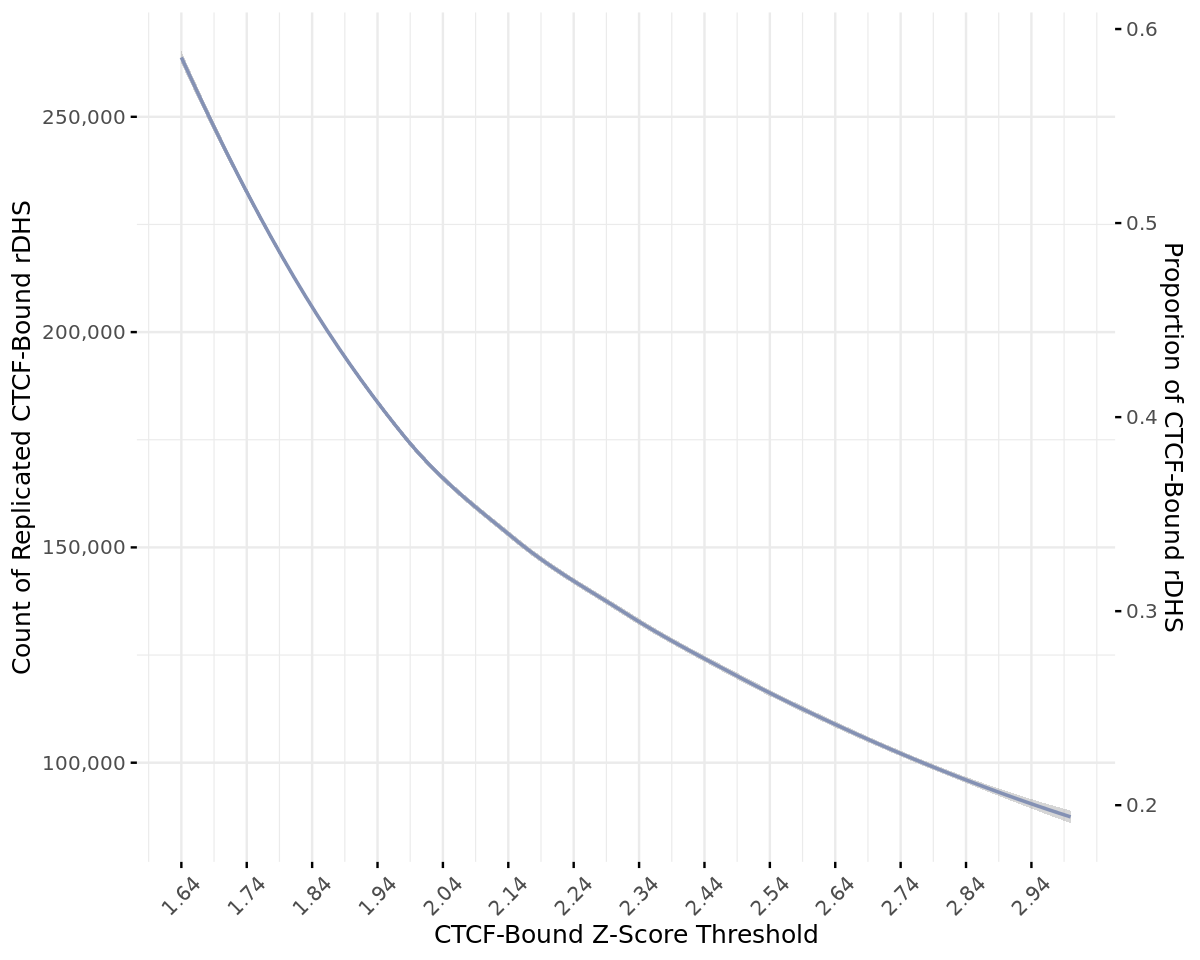

In [10]:
###
# Plotting
###

# Params
options(repr.plot.width=10, repr.plot.height=8)

# Smooth curve where x = threshold and y = number_replicated
S1C <- ggplot(ctcf_bound_replicated, aes(x = threshold, y = number_replicated)) +
  geom_smooth(method = "loess", color = GENERAL_COLOR)


# Customize the plot
S1C <- ggpar(S1C, 
  xlab = "CTCF-Bound Z-Score Threshold",
  ylab = "",
  ggtheme = theme_minimal(15),
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),  
    axis.title.x = element_text(margin = margin(t = 10)), 
  )
) + 
  scale_y_continuous(
    name = "Count of Replicated CTCF-Bound rDHS",
    # Second y axis using number_replicated / 450641
    sec.axis = sec_axis(~./450641, name = "Proportion of CTCF-Bound rDHS"),

    labels = scales::comma) +
    scale_x_continuous(breaks = seq(1.64, 3.01, 0.1)) +
    # Rotate xticks
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5))

S1C


### S1D

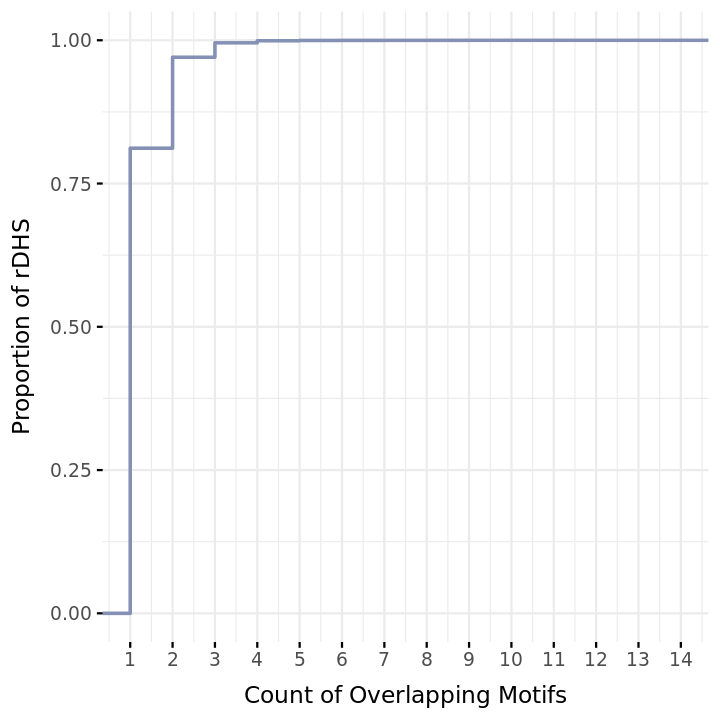

In [14]:
###
# Plot data
###

motif_counts_by_rdhs <- vroom(MOTIF_COUNTS_BY_RDHS, col_names = FALSE, show_col_types = FALSE)
colnames(motif_counts_by_rdhs) <- c("rDHS", "mid_count")

# Subset to those with motifs > 1
plot_data <- motif_counts_by_rdhs %>% 
  filter(mid_count > 0)

###
# Plot data
###

motif_counts_by_rdhs <- vroom(MOTIF_COUNTS_BY_RDHS, col_names = FALSE, show_col_types = FALSE)
colnames(motif_counts_by_rdhs) <- c("rDHS", "mid_count")

# Subset to those with motifs > 1
plot_data <- motif_counts_by_rdhs %>% 
  filter(mid_count > 0)

# ECDF plot
S1D <- ggecdf(plot_data$mid_count, 
        xlab = "Count of Overlapping Motifs",
        ylab = "Proportion of rDHS",
        color=GENERAL_COLOR,
        size=1,
        ggtheme = theme_minimal(14)) + scale_x_continuous(breaks = seq(0, max(plot_data$mid_count), 1)) + theme(
        axis.title.y = element_text(margin = margin(r = 10)),
        axis.title.x = element_text(margin = margin(t = 10)))


S1D

### S1 Call

Warning message:
“Unknown or uninitialised column: `n`.”
Warning message:
“Unknown or uninitialised column: `n`.”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Unknown or uninitialised column: `n`.”
Warning message:
“Unknown or uninitialised column: `n`.”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
`geom_smooth()` using formula = 'y ~ x'


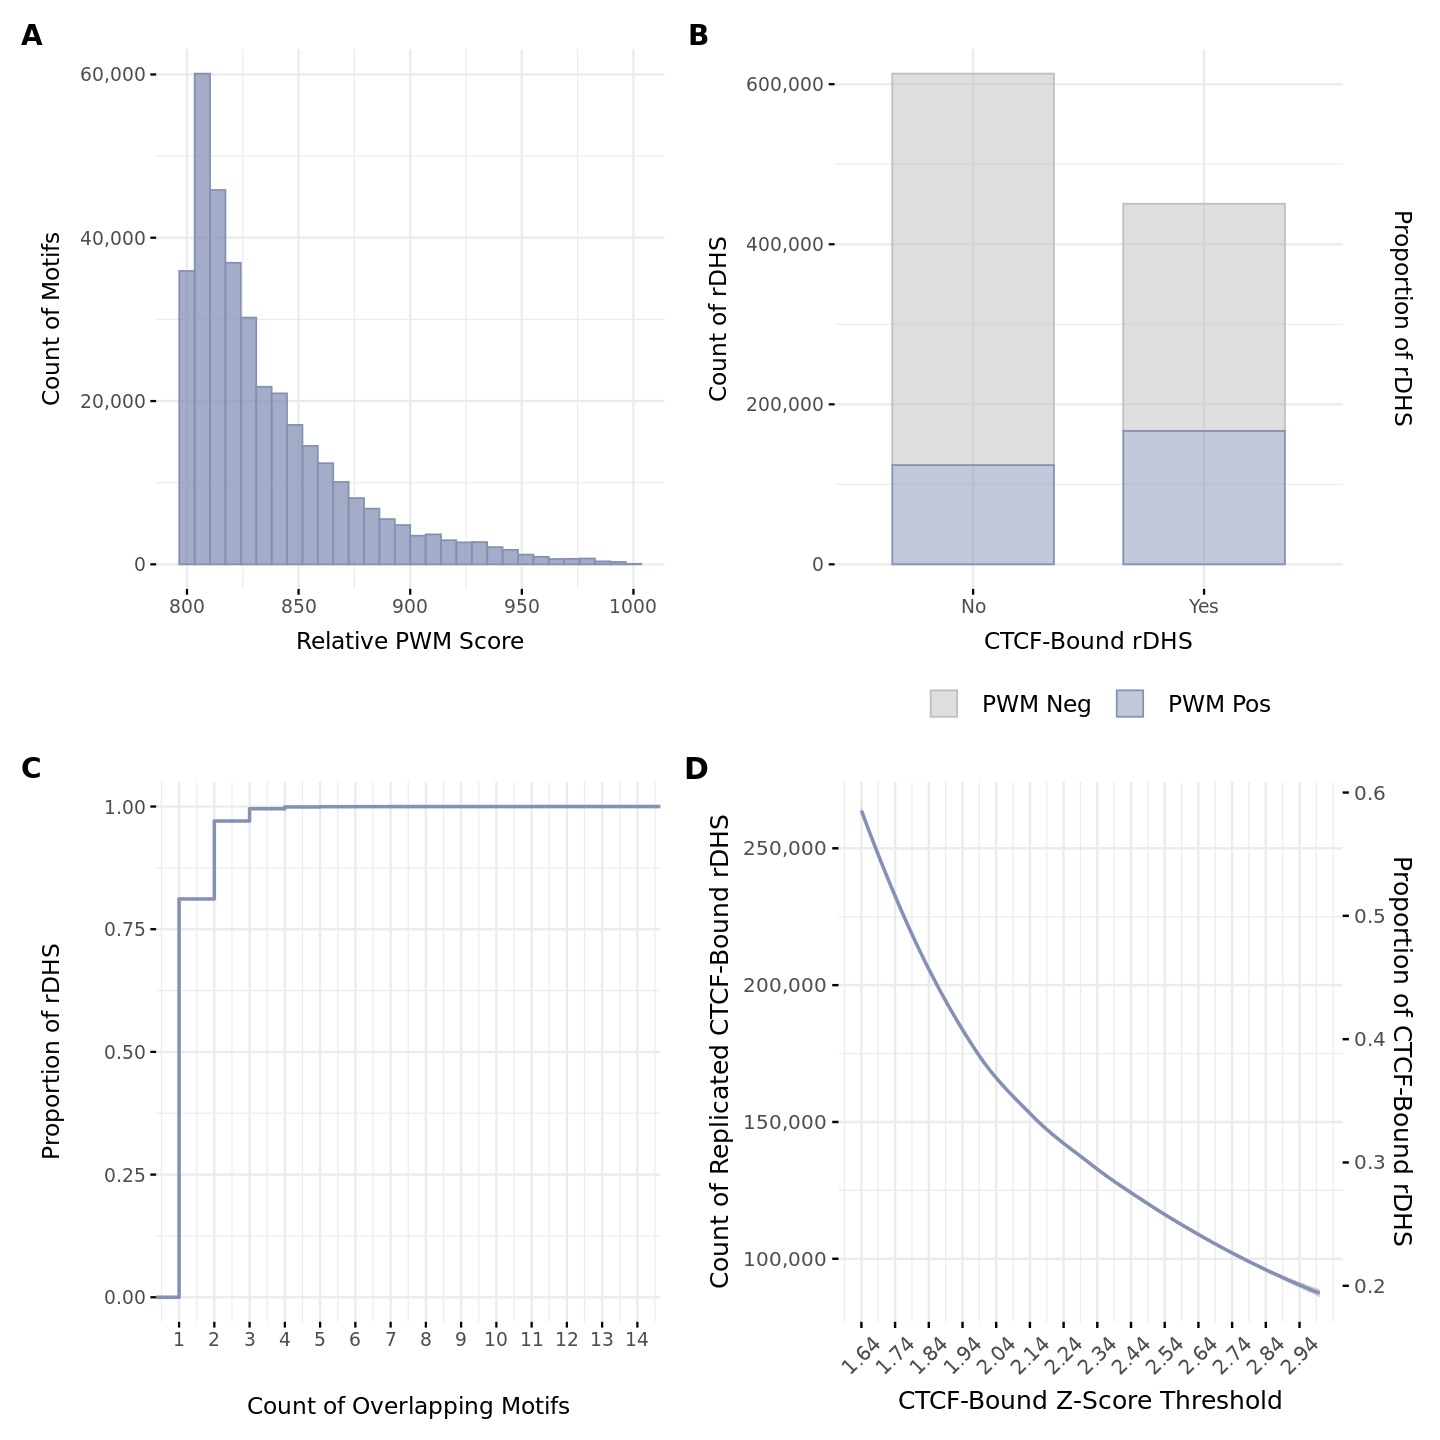

In [15]:
###
# Plotting
###

# Params
width <- 12
height <- 12
figname <- paste(SUPP_FIGURE_DIR, "S01.png", sep = "/")
options(repr.plot.width=width, repr.plot.height=height)

# Arrange the plots
((S1A | S1B) / (S1D | S1C) )+ plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(face = "bold"))

# Save figure, 300 dpi
ggsave(figname, width = width, height = height, dpi = 300)

## Suplement Fig 2

## S2A

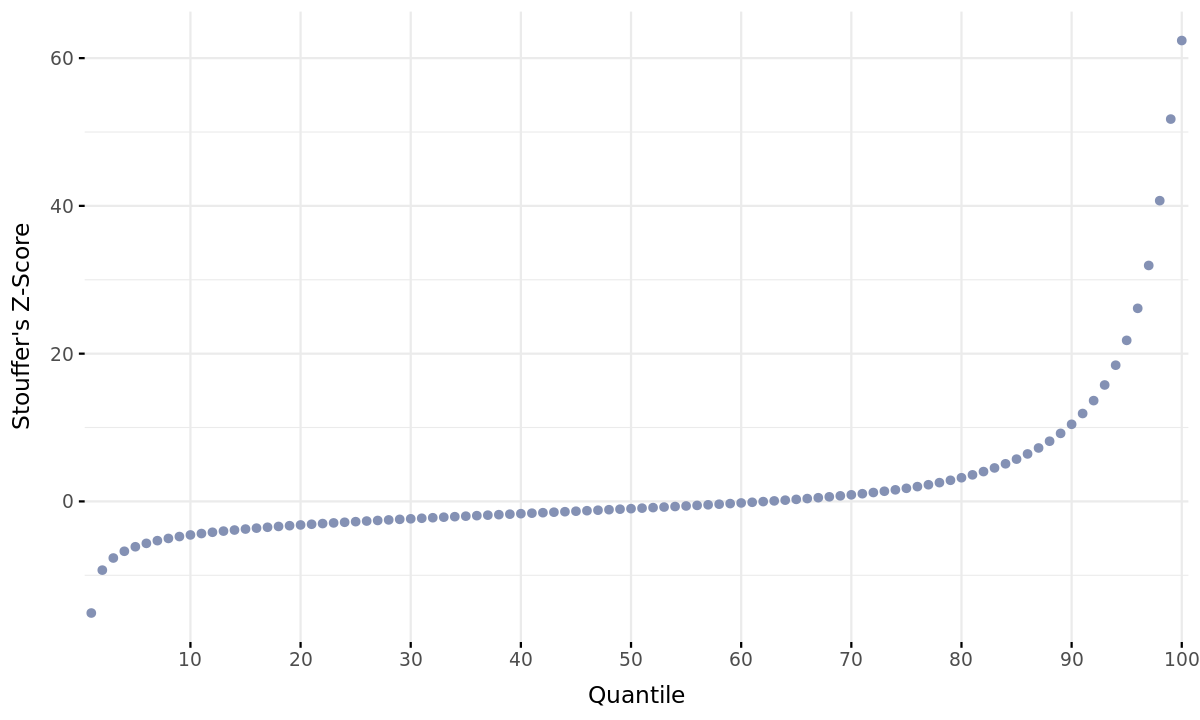

In [37]:
# Params
options(repr.plot.width=10, repr.plot.height=6)


activity_anno$activity_quantile <- as.factor(activity_anno$activity_quantile)

S2A <- ggerrorplot(data = activity_anno,
 x = "activity_quantile", 
 y = "zscore_meta_masked", 
 error_x = "activity_quantile", 
 error_y = "zscore_meta_masked", 
 error_type = "ci",
 width = 1.75,
 size = 0.35,
 color = GENERAL_COLOR,
 fill = "grey",
 alpha = 0.5,
 xlab = "Quantile",
 ylab = "Stouffer's Z-Score",
 ggtheme = theme_minimal(14)) + 
 scale_x_discrete(breaks = seq(0, 100, by = 10)) + 
 theme(
        axis.title.y = element_text(margin = margin(r = 10)), 
        axis.title.x = element_text(margin = margin(t = 10)))  

S2A

## S2 Call

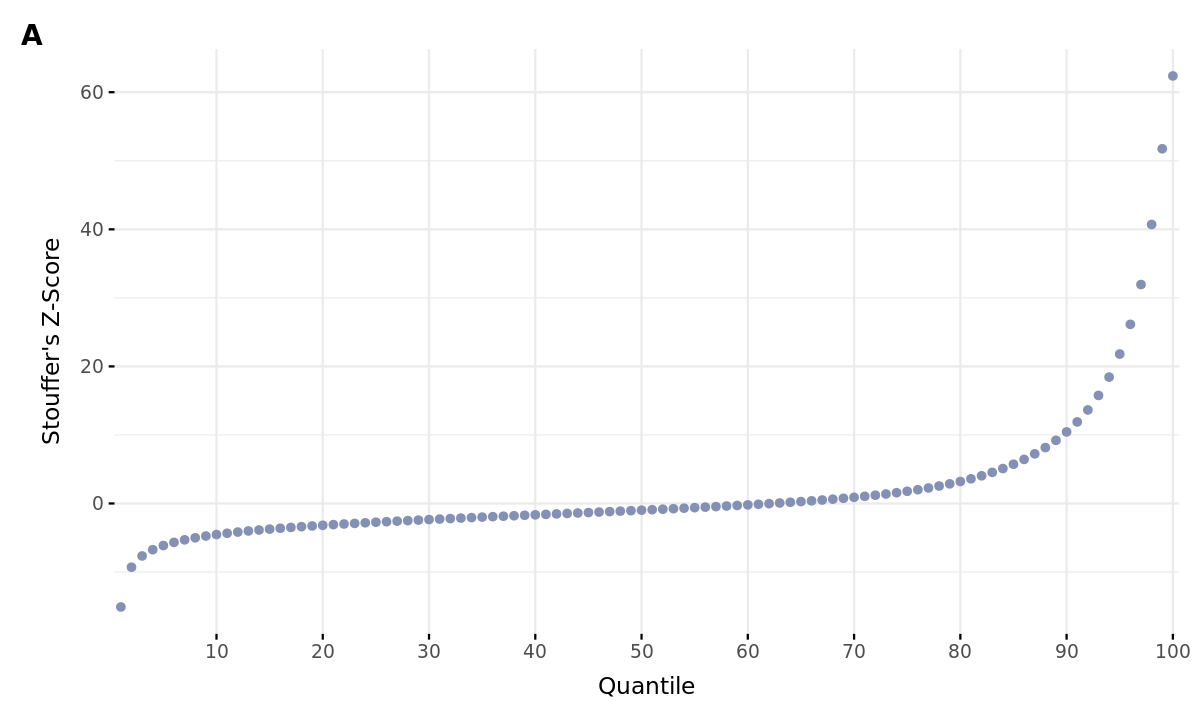

In [38]:
###
# Plotting
###

# Params
width <- 10
height <- 6
figname <- paste(SUPP_FIGURE_DIR, "S02.png", sep = "/")
options(repr.plot.width=width, repr.plot.height=height)

# Arrange the plots
(S2A) + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(face = "bold"))

# Save figure, 300 dpi
ggsave(figname, width = width, height = height, dpi = 300)

## Suplement Fig 3

## S3A-C

In [83]:
###
# Plot data
###

# Select zscore_meta_masked_norm_quantile, linsight, gerp++, phlyoP100, phastcons100
plot_data <- matrix %>% 
  select(activity_quantile, linsight, `gerp++`, phylop100, phastcons100)

# Pivor to long format
plot_data <- plot_data %>% 
  pivot_longer(cols = c(linsight, `gerp++`, phylop100, phastcons100), names_to = "metric", values_to = "value")

# Conserved thresholds
gerp_threshold <- 2
linsight_threshold <- 0.8
phastcons_threshold <- 0.8
phylop100_threshold <- 1

# Initialize an empty list to store the data frames
list_of_data_frames <- list()

# Repeat the operation 10 times
set.seed(123)
for (i in 1:10) {
  # Sample with replacement
  sampled_data <- plot_data %>% sample_n(10000, replace = TRUE)
  
  # Add the 'conserved' column
  sampled_data <- sampled_data %>% 
    mutate(conserved = case_when(
      metric == "linsight" & value >= linsight_threshold ~ 1,
      metric == "gerp++" & value >= gerp_threshold ~ 1,
      metric == "phylop100" & value >= phylop100_threshold ~ 1,
      metric == "phastcons100" & value >= phastcons_threshold ~ 1,
      TRUE ~ 0
    ))

  # Groupby by zscore_meta_masked_norm_quantile, metric and calculate proportion of conserved
  sampled_data <- sampled_data %>% 
    group_by(activity_quantile, metric) %>% 
    summarize(prop_conserved = sum(conserved) / n())
  
  # Add the sampled data to the list
  list_of_data_frames[[i]] <- sampled_data
}

# Combine all data frames in the list into a single data frame in long format
all_data_long <- bind_rows(list_of_data_frames)

`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile'. You can

In [89]:
###
# Plotting
###
options(repr.plot.width=16, repr.plot.height=6)


###
# A
###

S3A <- ggplot(all_data_long %>% 
                filter(metric == "phastcons100"), 
              aes(x = activity_quantile, y = prop_conserved)) +
  geom_smooth(color=GENERAL_COLOR, size=0.60)

S3A <- ggpar(S3A, 
  xlab="Binding Activity Quantile",
  ylab="Proportion of Conserved Bases",
  ggtheme=theme_minimal(16),
  ) +
    theme(legend.text = element_text(size=14, angle = 90, margin = margin(t = 10)), legend.spacing.x = unit(0.5, "cm"), legend.spacing.y = unit(0.5, "cm"))+
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))   # Add space to the right of the y-axis label
  ) + 
    stat_cor(method = "pearson", color='red', size=5, label.y = 0.2, label.x=20) + 
  scale_x_continuous(breaks = seq(0, 100, 10)) +
    coord_cartesian(ylim = c(0, 0.40))


###
# B
###

S3B <- ggplot(all_data_long %>% 
                filter(metric == "gerp++"), 
              aes(x = activity_quantile, y = prop_conserved)) +
  geom_smooth(color=GENERAL_COLOR, size=0.60)

S3B <- ggpar(S3B, 
  xlab="Binding Activity Quantile",
  ylab="",
  ggtheme=theme_minimal(16),
  ) +
    theme(legend.text = element_text(size=14, angle = 90, margin = margin(t = 10)), legend.spacing.x = unit(0.5, "cm"), legend.spacing.y = unit(0.5, "cm")) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))   # Add space to the right of the y-axis label
  ) + 
    stat_cor(method = "pearson", color='red', size=5, label.y = 0.25, label.x=25) + 
  scale_x_continuous(breaks = seq(0, 100, 10)) +
  # remove y ticks and label
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank()) +
    coord_cartesian(ylim = c(0, 0.40))



###
# C
###

S3C <- ggplot(all_data_long %>% 
                filter(metric == "linsight"), 
              aes(x = activity_quantile, y = prop_conserved)) +
  geom_smooth(color=GENERAL_COLOR, size=0.60)

S3C <- ggpar(S3C, 
  xlab="Binding Activity Quantile",
  ylab="",
  ggtheme=theme_minimal(16),
  ) +
    theme(legend.text = element_text(size=14, angle = 90, margin = margin(t = 10)), legend.spacing.x = unit(0.5, "cm"), legend.spacing.y = unit(0.5, "cm")) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))   # Add space to the right of the y-axis label
  ) + 
    stat_cor(method = "pearson", color='red', size=5, label.y = 0.10, label.x=25) + 
  scale_x_continuous(breaks = seq(0, 100, 10)) +
    coord_cartesian(ylim = c(0, 0.40)) +
  # remove y ticks and label
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

### S3 Call

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


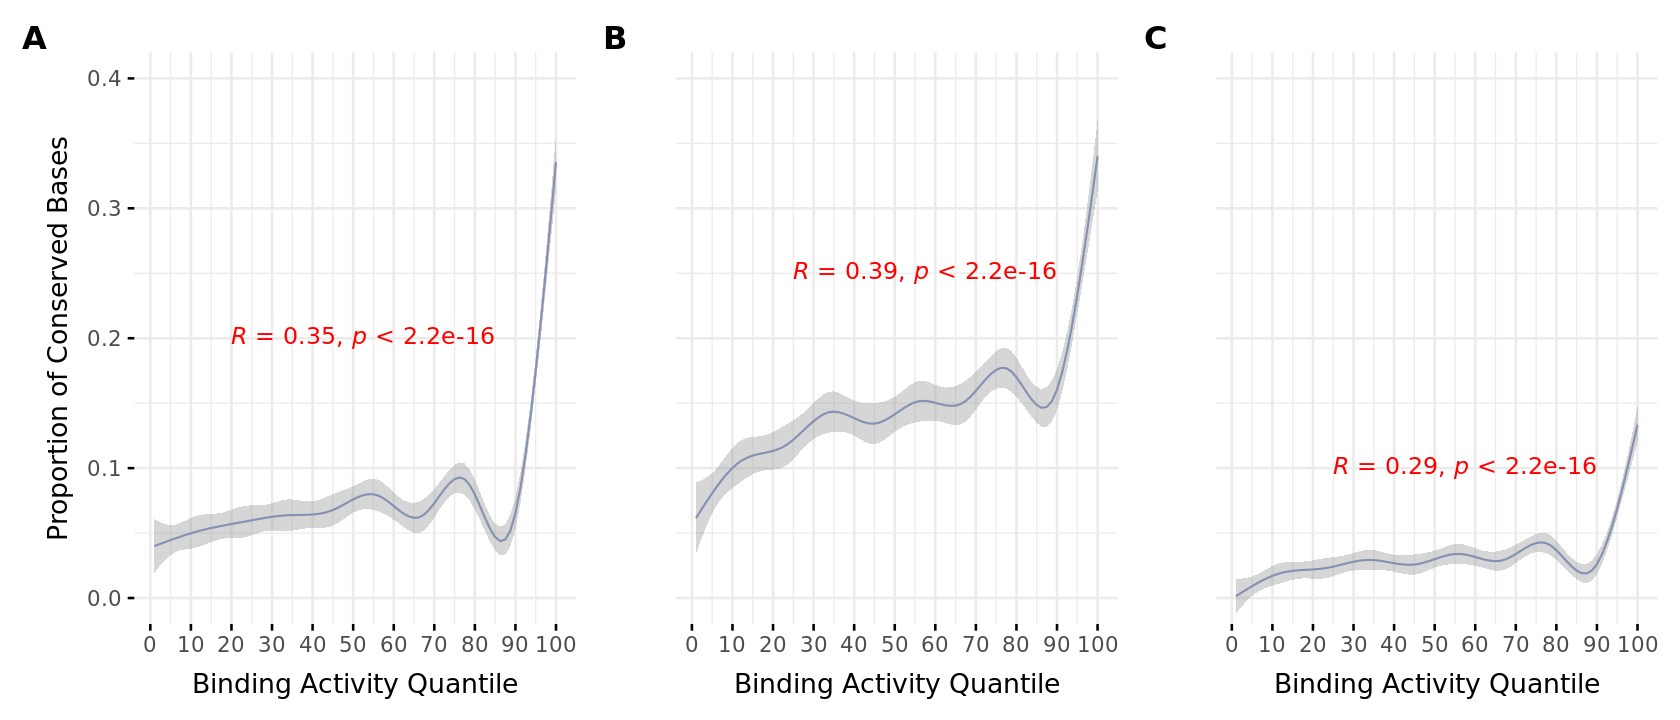

In [90]:
###
# Call
###

# Params
width <- 14
height <- 6
figname <- paste(SUPP_FIGURE_DIR, "S03.png", sep = "/")
options(repr.plot.width=width, repr.plot.height=height)

# Call
(S3A | S3B | S3C) + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(face = "bold"))

# Save figure, 300 dpi
ggsave(figname, width = width, height = height, dpi = 300)

## Supplementary Figure 4

In [7]:
###
# Plot Data
###

# Initialize an empty list to store the data frames
list_of_data_frames <- list()

# Repeat the operation 10 times
set.seed(111)
for (i in 1:10) {
  # Subset and Sample with replacement
  plot_data <- matrix %>% 
    filter(vid != "NaN" & !is.na(caddPhred & dpwm_class!="NaN")) %>%
    select(vid, activity_quantile, caddPhred, dpwm, dpwm_class, pwm_stat_class) %>%
    sample_n(10000, replace = TRUE)

  # Flag pathogenic if caddPhred >= 10
  plot_data <- plot_data %>% 
    mutate(pathogenic = ifelse(caddPhred >= 10, 1, 0))

  # Groupby by zscore_meta_masked_norm_quantile and calculate proportion of pathogenic
  plot_data <- plot_data %>% 
    group_by(activity_quantile, dpwm_class, pwm_stat_class) %>% 
    summarize(prop_pathogenic = sum(pathogenic) / n(),
    n=n())

  # Add the sampled data to the list
  list_of_data_frames[[i]] <- plot_data
}

# Combine all data frames in the list into a single data frame in long format
all_data_long <- bind_rows(list_of_data_frames)

# Confirm factor
all_data_long$dpwm_class <- factor(all_data_long$dpwm_class)
# Repalce pwm_stat_class: 1 = sig, 0 = not sig
all_data_long <- all_data_long %>% 
  mutate(pwm_stat_class = ifelse(pwm_stat_class == 1, "Yes", "No"))
all_data_long$pwm_stat_class <- factor(all_data_long$pwm_stat_class)

`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile', 'dpwm_class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'activity_quantile',

### S4A

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


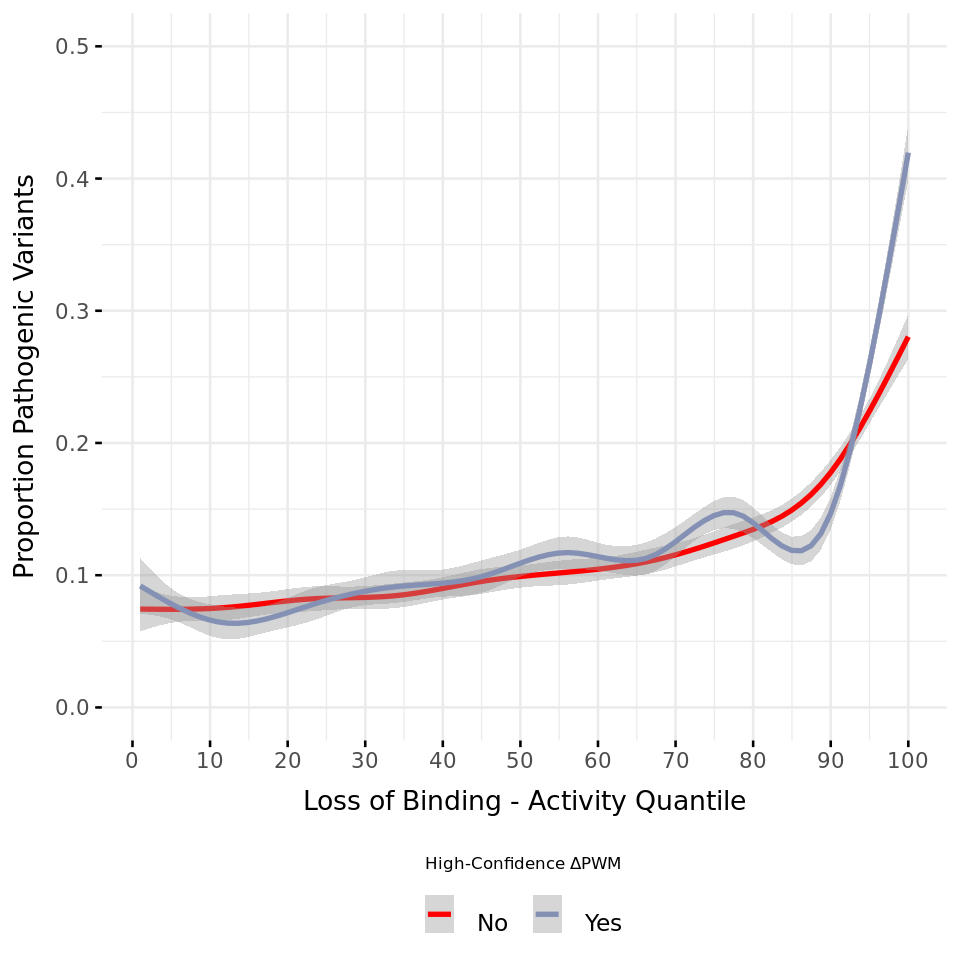

In [8]:
###
# Plot data
###

plot_data <- all_data_long %>% filter(dpwm_class=="LoB")

###
# Plotting
###

options(repr.plot.width=8, repr.plot.height=8)


S4A <- ggplot(plot_data, 
  aes(x = activity_quantile, y = prop_pathogenic, color=pwm_stat_class)) +
  #aes(x = activity_quantile, y = prop_pathogenic)) +
  geom_smooth(size=0.60, linewidth=1.5) + 
  scale_color_manual(values = c("Yes" = GENERAL_COLOR, "No" = "red")) +
  scale_x_continuous(breaks = seq(0, 100, 10))



S4A <- ggpar(S4A, 
  xlab = "Loss of Binding - Activity Quantile",
  ylab = "Proportion Pathogenic Variants",
  ggtheme = theme_minimal(16)
) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10)),  # Add space to the right of the y-axis label
    axis.title.x = element_text(margin = margin(t = 10)),  # Add space to the right of the y-axis label
    legend.position = "bottom",
    legend.title = element_text(face = "bold", size = 10),
    legend.text = element_text(size = 14, angle = 0, margin = margin(t = 10)),
    legend.spacing.x = unit(0.5, "cm"),
    legend.spacing.y = unit(0.5, "cm"),
  ) +
  guides(color = guide_legend(title = "High-Confidence ΔPWM", title.position = "top", title.theme = element_text(size = 10))) +
  coord_cartesian(ylim = c(0, 0.50))

# Call
S4A

#### Statistics on 90th quantile or higher

In [23]:
# Subset to activity_quantile >=90, groupby pwm_stat_calss and calculate t-test on prop_pathogenic
all_data_long %>% 
  filter(activity_quantile >= 95 & dpwm_class=="GoB") %>% 
  group_by(pwm_stat_class) %>% 
  summarize(mean_prop_pathogenic = mean(prop_pathogenic),
            sd_prop_pathogenic = sd(prop_pathogenic),
            n = n())

pwm_stat_class,mean_prop_pathogenic,sd_prop_pathogenic,n
<fct>,<dbl>,<dbl>,<int>
No,0.2377814,0.1066744,60
Yes,0.2235306,0.1005805,60


In [21]:
t.test(
  prop_pathogenic ~ pwm_stat_class, 
  data = all_data_long %>% filter(activity_quantile >= 95 & dpwm_class=="LoB")
)


	Welch Two Sample t-test

data:  prop_pathogenic by pwm_stat_class
t = -3.2128, df = 88.955, p-value = 0.001831
alternative hypothesis: true difference in means between group No and group Yes is not equal to 0
95 percent confidence interval:
 -0.11567538 -0.02727026
sample estimates:
 mean in group No mean in group Yes 
        0.2582302         0.3297030 


### S4B

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


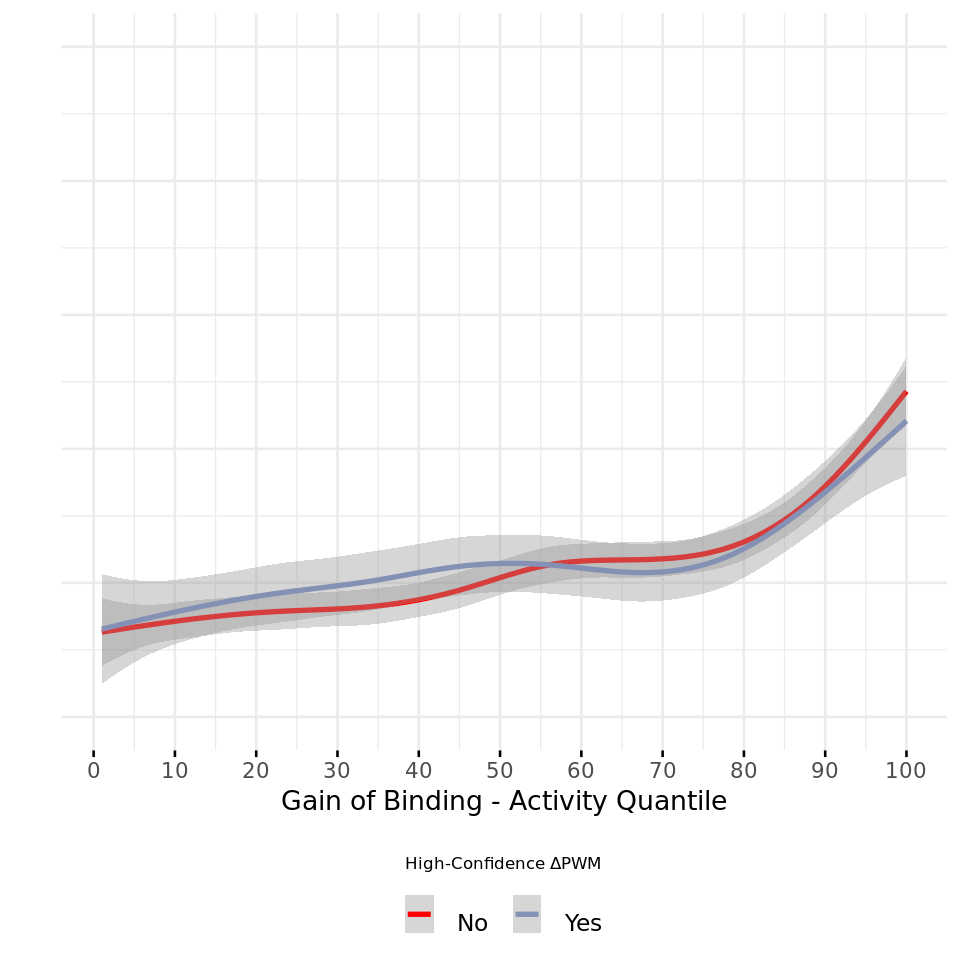

In [102]:
###
# Plot data
###

plot_data <- all_data_long %>% filter(dpwm_class=="GoB")

###
# Plotting
###

options(repr.plot.width=8, repr.plot.height=8)

#
S4B <- ggplot(plot_data, 
  aes(x = activity_quantile, y = prop_pathogenic, color=pwm_stat_class)) +
  geom_smooth(size=0.60, linewidth=1.5) + 
  scale_color_manual(values = c("Yes" = GENERAL_COLOR, "No" = "red")) +
  theme_minimal(base_size = 14) +
  theme(
        axis.title.y = element_text(margin = margin(r = 10)),  # Add space to the right of the y-axis label
        axis.title.x = element_text(margin = margin(t = 10)),  # Add space to the right of the y-axis label
        legend.position = "bottom",
        legend.title = element_text(face = "bold", size = 10),
        legend.text = element_text(size=14, angle = 00, margin = margin(t = 10)),
        legend.spacing.x = unit(0.5, "cm"),
        legend.spacing.y = unit(0.5, "cm")) +
  guides(color = guide_legend(title = "High-Confidence dPWM", title.position = "top", title.theme = element_text(face = "bold", size = 10))) +
  scale_x_continuous(breaks = seq(0, 100, 10)) + 
  coord_cartesian(ylim = c(0, 0.50)) +
  # remove y ticks and label
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())


S4B <- ggpar(S4B, 
  xlab = "Gain of Binding - Activity Quantile",
  ylab = "",
  ggtheme = theme_minimal(16)
) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10))  # Add space to the right of the y-axis label
  )+
  theme(legend.position = "bottom",
        legend.title = element_text(face = "bold", size = 10),
        legend.text = element_text(size=14, angle = 00, margin = margin(t = 10)),
        legend.spacing.x = unit(0.5, "cm"),
        legend.spacing.y = unit(0.5, "cm")) +
  guides(color = guide_legend(title = "High-Confidence ΔPWM", title.position = "top", title.theme = element_text(size = 10))) +
    coord_cartesian(ylim = c(0, 0.50)) +
    # remove y ticks and label
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

S4B

#### S4 Call

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


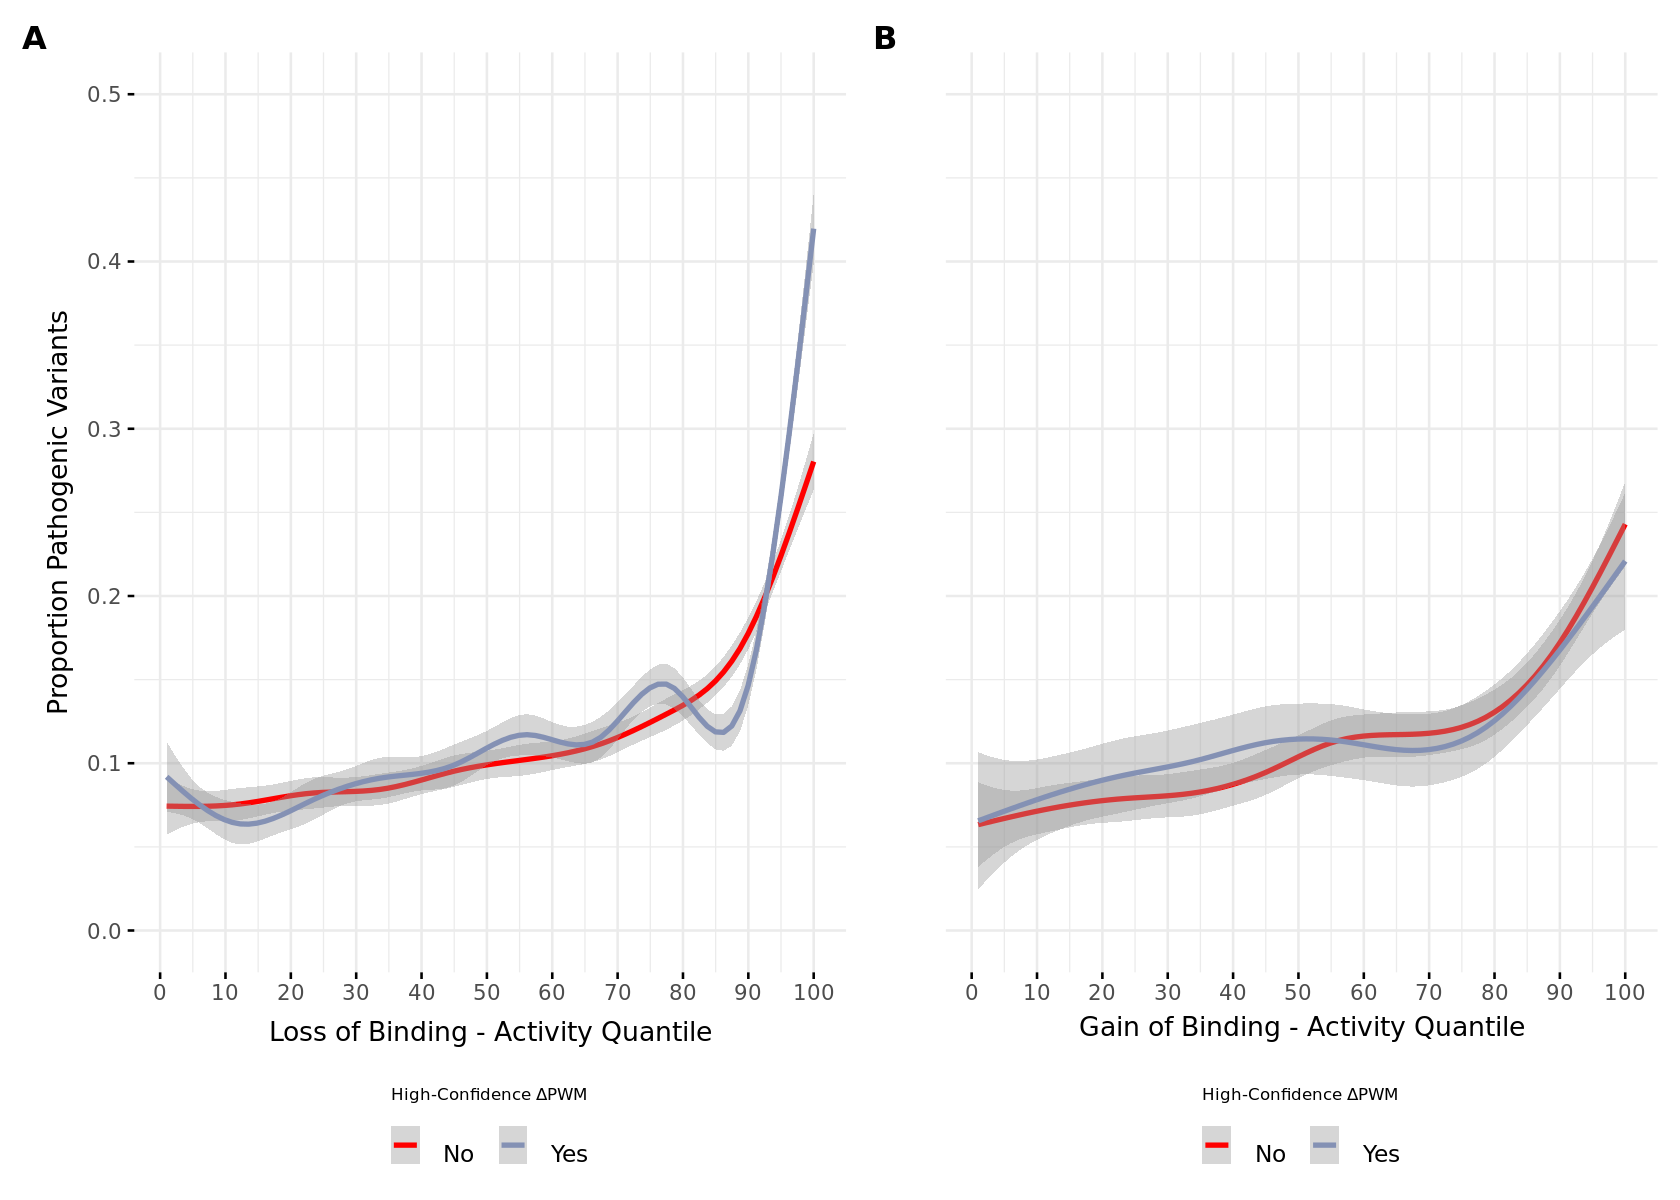

In [103]:
###
# Call
###

# Params
width <- 14
height <- 10
figname <- paste(SUPP_FIGURE_DIR, "S04.png", sep = "/")
options(repr.plot.width=width, repr.plot.height=height)

# Call
(S4A | S4B) + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(face = "bold"))

# Save figure, 300 dpi
ggsave(figname, width = width, height = height, dpi = 300)

## Supplementary Figure 5

In [3]:
###
# Plot data
###

# Read in maps
maps <- vroom("results/figures/all_maps.tsv", show_col_types=FALSE)

# Confirm factors
maps <- maps %>% 
  mutate(pwm_stat_class = ifelse(pwm_stat_class == 1, "Yes", "No"))
maps$pwm_stat_class <- factor(maps$pwm_stat_class)

### S5A

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


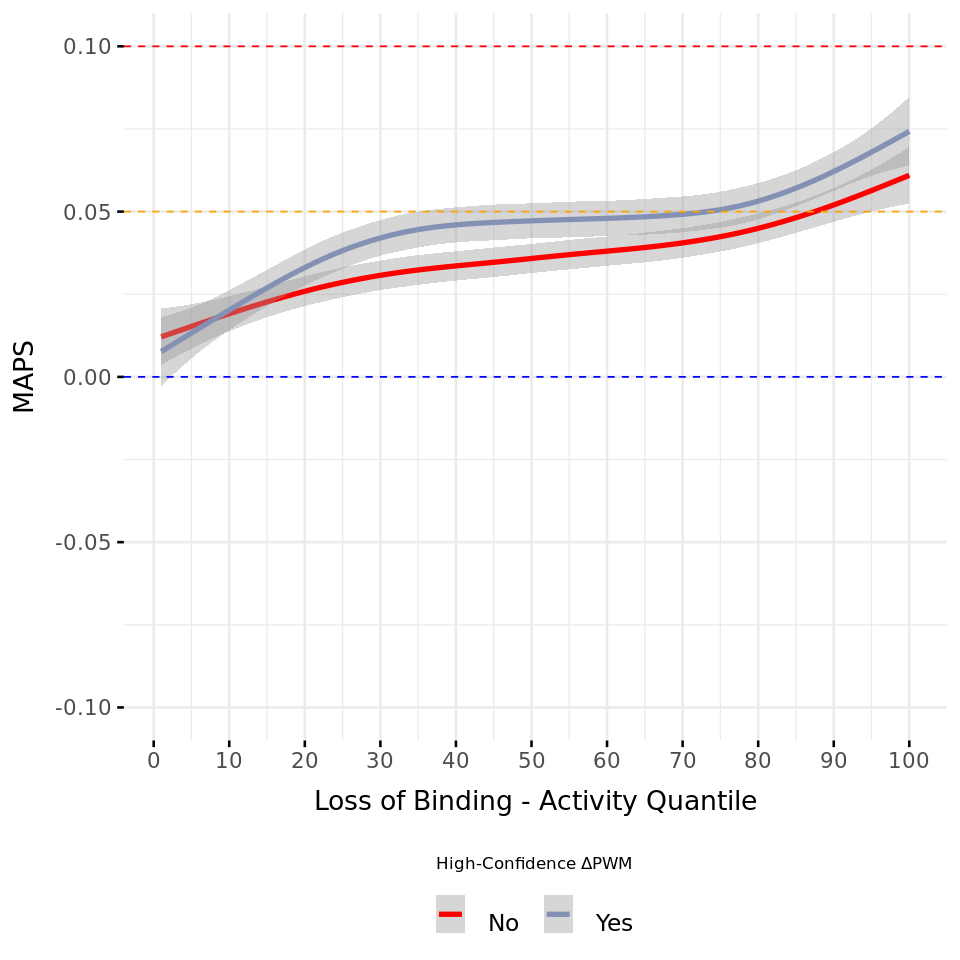

In [20]:
###
# Plot data
###

plot_data <- maps %>% filter(dpwm_class=="LoB")

###
# Plotting
###

options(repr.plot.width=8, repr.plot.height=8)

#
S5A <- ggplot(maps %>% filter(dpwm_class=="LoB"),
   aes(x = activity_quantile_mid, y = maps, color=pwm_stat_class)) +
  geom_smooth(method='gam', size=1.5, linewidth=1.5) +
  scale_color_manual(values = c("Yes" = GENERAL_COLOR, "No" = "red")) +
   scale_fill_manual(values = c("LoB" = "#95D840FF")) +
  geom_hline(yintercept = 0,  color='blue', linetype = "dashed") + 
  geom_hline(yintercept = 0.05, color='orange', linetype = "dashed") +
  geom_hline(yintercept = 0.1, color='red', linetype = "dashed") +
  scale_x_continuous(breaks = seq(0, 100, 10))



S5A <- ggpar(S5A, 
  xlab = "Loss of Binding - Activity Quantile",
  ylab = "MAPS",
  ggtheme = theme_minimal(16)
) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10))  # Add space to the right of the y-axis label
  )+
  theme(
        axis.title.y = element_text(margin = margin(r = 10)),  # Add space to the right of the y-axis label
        axis.title.x = element_text(margin = margin(t = 10)),  # Add space to the right of the y-axis label
        legend.position = "bottom",
        legend.title = element_text(face = "bold", size = 10),
        legend.text = element_text(size=14, angle = 00, margin = margin(t = 10)),
        legend.spacing.x = unit(0.5, "cm"),
        legend.spacing.y = unit(0.5, "cm")) +
 guides(color = guide_legend(title = "High-Confidence ΔPWM", title.position = "top", title.theme = element_text(size = 10)))  +
    coord_cartesian(ylim = c(-0.10, 0.10))


# Call
S5A

### S5B

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


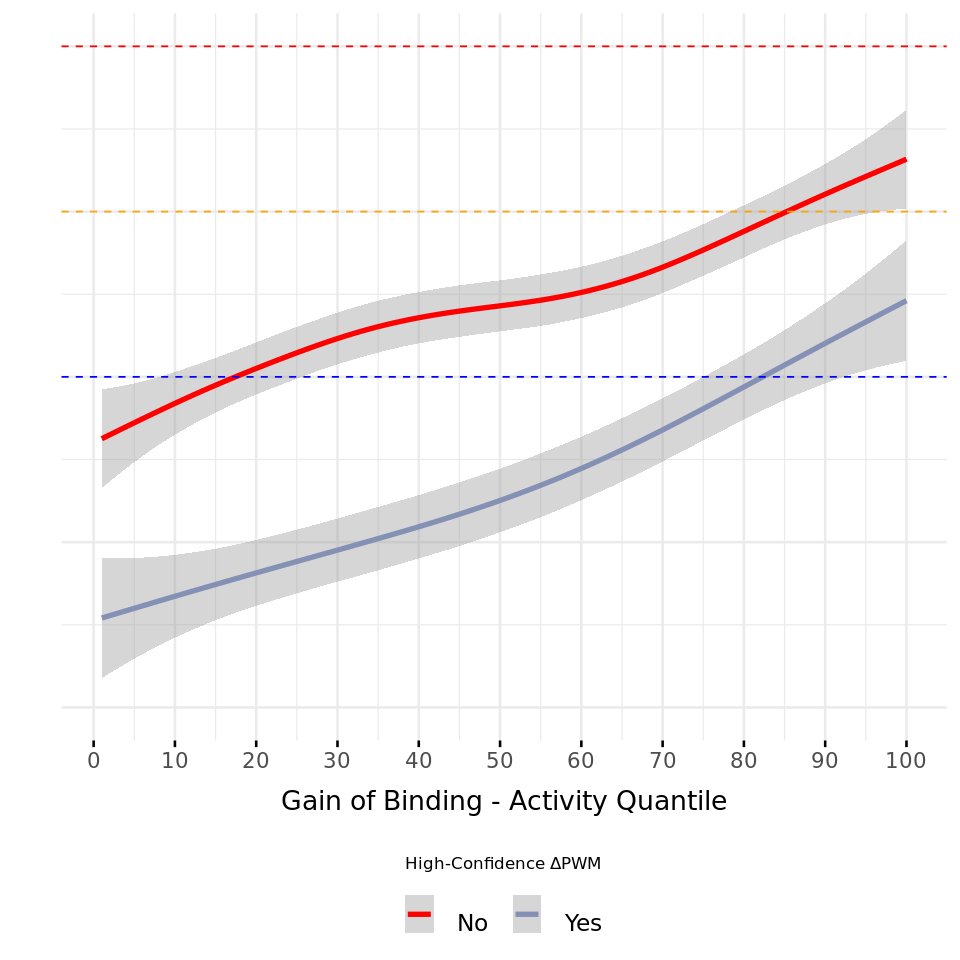

In [21]:
###
# Plot data
###

plot_data <- maps %>% filter(dpwm_class=="GoB")

###
# Plotting
###

options(repr.plot.width=8, repr.plot.height=8)

S5B <- ggplot(plot_data, aes(x = activity_quantile_mid, y = maps, color=pwm_stat_class)) +
  geom_smooth(method='gam', size=1.5, linewidth=1.5) +
  scale_color_manual(values = c("Yes" = GENERAL_COLOR, "No" = "red")) +
  theme_minimal(16) + 
  geom_hline(yintercept = 0,  color='blue', linetype = "dashed") + 
  geom_hline(yintercept = 0.05, color='orange', linetype = "dashed") +
  geom_hline(yintercept = 0.1, color='red', linetype = "dashed") +
  scale_x_continuous(breaks = seq(0, 100, 10))



S5B <- ggpar(S5B, 
  xlab = "Gain of Binding - Activity Quantile",
  ylab = "",
  ggtheme = theme_minimal(16)
) +
  theme(
    axis.title.y = element_text(margin = margin(r = 10))  # Add space to the right of the y-axis label
  )+
  theme(
        axis.title.y = element_text(margin = margin(r = 10)),  # Add space to the right of the y-axis label
        axis.title.x = element_text(margin = margin(t = 10)),  # Add space to the right of the y-axis label
        legend.position = "bottom",
        legend.title = element_text(face = "bold", size = 10),
        legend.text = element_text(size=14, angle = 00, margin = margin(t = 10)),
        legend.spacing.x = unit(0.5, "cm"),
        legend.spacing.y = unit(0.5, "cm")) +
 guides(color = guide_legend(title = "High-Confidence ΔPWM", title.position = "top", title.theme = element_text(size = 10))) +
    coord_cartesian(ylim = c(-0.1, 0.10)) +
    # remove y ticks and label
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())




# Call
S5B

#### S5 call

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


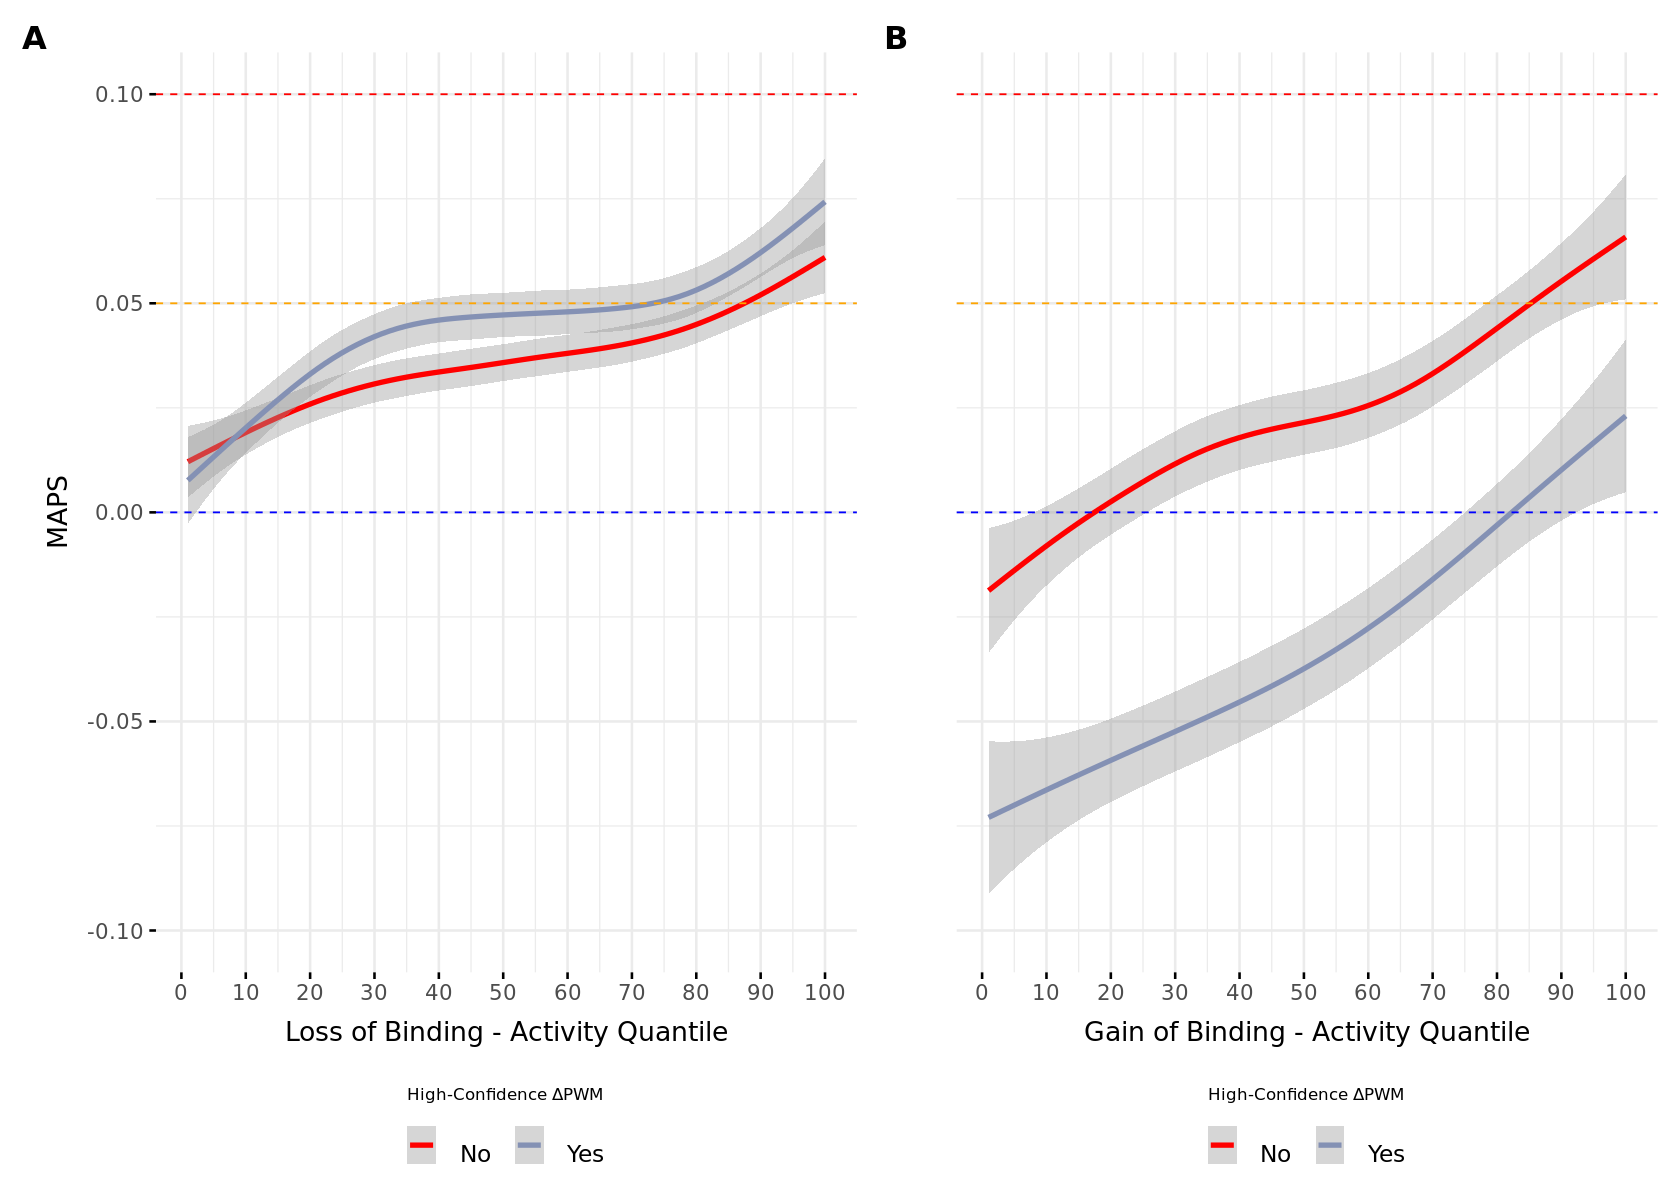

In [22]:
###
# Call
###

# Params
width <- 14
height <- 10
figname <- paste(SUPP_FIGURE_DIR, "S05.png", sep = "/")
options(repr.plot.width=width, repr.plot.height=height)

# Call
(S5A | S5B) + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(face = "bold"))

# Save figure, 300 dpi
ggsave(figname, width = width, height = height, dpi = 300)

## Supplementary Figure 6

### S6A

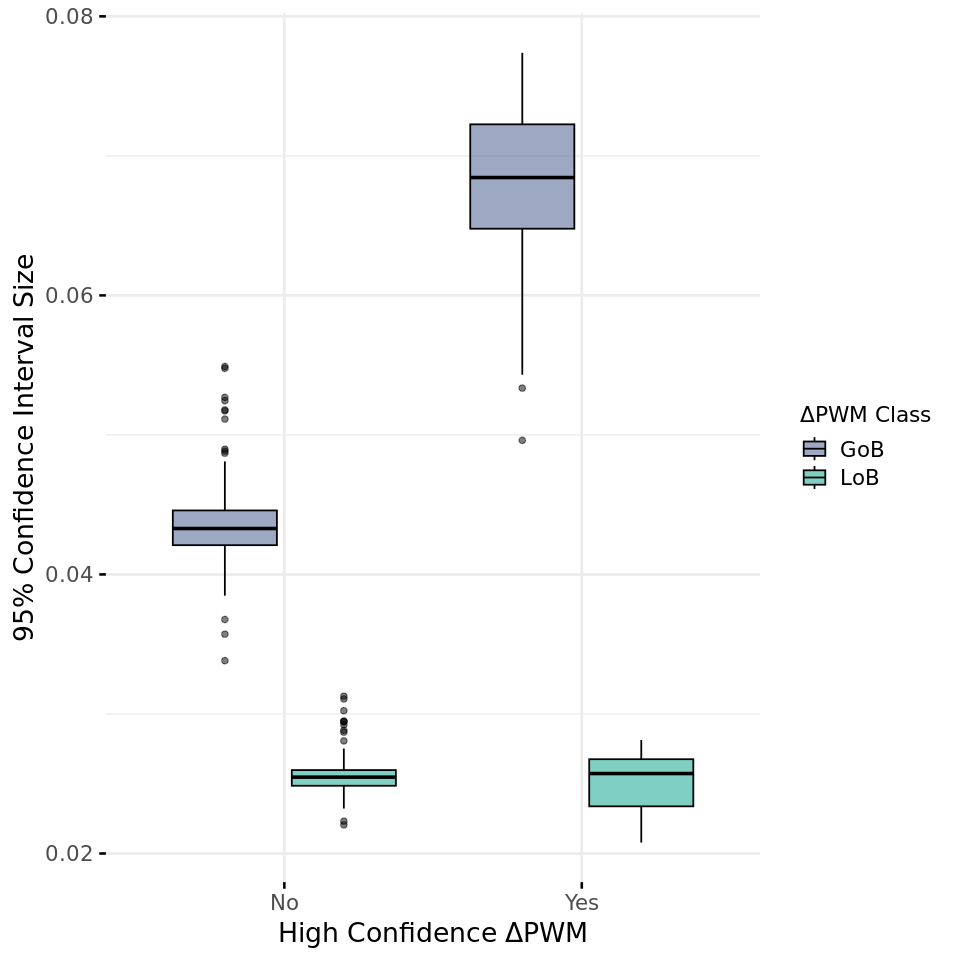

In [26]:
# Add confidenc on proportion
plot_data <- maps %>%
    rowwise() %>%
    mutate(
    binom_p_value = binom.test(singleton_count, context_nvar)$p.value,
    binom_conf_int = list(binom.test(singleton_count, context_nvar)$conf.int),
    binom_estimate = binom.test(singleton_count, context_nvar)$estimate,
    binom_conf_size = binom_conf_int[2] - binom_conf_int[1]
    ) %>%
ungroup()

S6A <- ggboxplot(plot_data, 
          x = "pwm_stat_class", 
          y = "binom_conf_size", 
          fill = "dpwm_class", 
          alpha = 0.5, 
          palette = c("LoB" = LOB_COLOR_CODE, "GoB" = GOB_COLOR_CODE)) +
  labs(y = "95% Confidence Interval Size", 
       x = "High Confidence ΔPWM", 
       fill = "ΔPWM Class") +
  theme(
        axis.title.y = element_text(margin = margin(r = 10)),  # Add space to the right of the y-axis label
        axis.title.x = element_text(margin = margin(t = 10)),  # Add space to the right of the y-axis label
        legend.position = "bottom",
        legend.title = element_text(face = "bold", size = 10),
        legend.text = element_text(size=14, angle = 00, margin = margin(t = 10)),
        legend.spacing.x = unit(0.5, "cm"),
        legend.spacing.y = unit(0.5, "cm")) +
  guides(fill = guide_legend(title = "ΔPWM Class", title.position = "top", title.theme = element_text( size = 13)))

S6A <- ggpar(S6A, ggtheme = theme_minimal(16))

# Call 
S6A

#### S6 Call

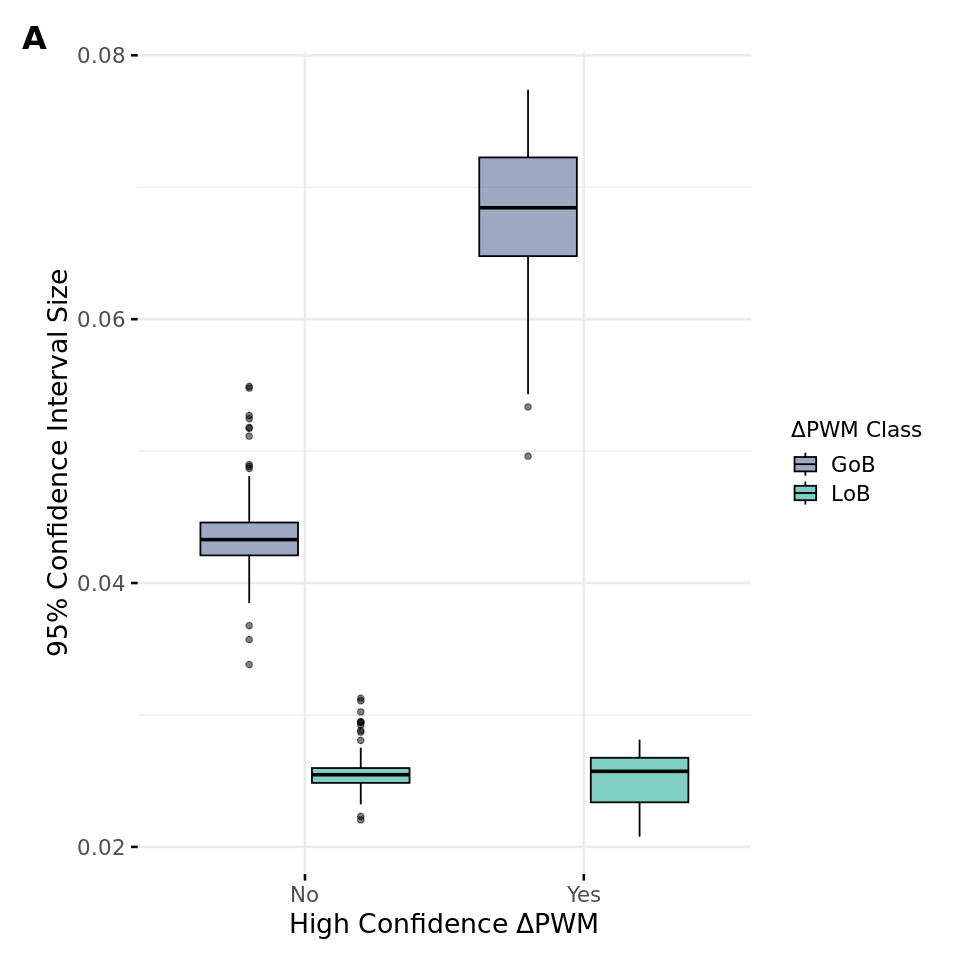

In [27]:
###
# Call
###

# Params
width <- 8
height <- 8
figname <- paste(SUPP_FIGURE_DIR, "S06.png", sep = "/")
options(repr.plot.width=width, repr.plot.height=height)

# Call
(S6A) + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(face = "bold"))

# Save figure, 300 dpi
ggsave(figname, width = width, height = height, dpi = 300)